<a href="https://colab.research.google.com/github/Andrea987/advtrain-linreg/blob/main/notebooks/fig1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
pip install miceforest

In [39]:
#pip install gcimpute

In [2]:
from re import VERBOSE
from itertools import cycle
import miceforest as mf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.linear_model import lasso_path
from sklearn import datasets
from sklearn import linear_model
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import ridge_regression
import tqdm
import cvxpy as cp
print(cp.installed_solvers())
import numpy as np
import copy

import traceback


def compute_q(p):
    if p != np.inf and p > 1:
        q = p / (p - 1)
    elif p == 1:
        q = np.inf
    else:
        q = 1
    return q


class AdversarialTraining:
    def __init__(self, X, y, S_dict, p):  # S is the matrix such that ||S^(-1) @ Dx||\leq delta. As a consequence, S appears in the unconstrained problem
        # S: (d, d) matrix, or S = np.concatenate(tS), with tS = [S1,..,S_m], so S is (d * n, d)
        n, d = X.shape
        q = compute_q(p)

        #print("who is X", X)
        #print("who is y", y)
        #print("who is S", S)
        #print("who is q in AdversarialTraining: ", q)
        #Formulate problem
        param = cp.Variable(d)
        #print("shape param ", param.shape)
        #print("dim ", n)
        print("X ", n," ", d)
        print("y shape", y.shape)
        #print("S_dict ", S_dict)
        #print("S in adv training", S)
        print("nm ", d*n)
        S_dts = S_dict['S_dts']
        S_mis = S_dict['S_mis']
        adv_radius_times_scale_dts = cp.Parameter(name='adv_radius_times_dts', nonneg=True)
        adv_radius_times_scale_mis = cp.Parameter(name='adv_radius_times_mis', nonneg=True)
        #scale_dts = cp.Parameter(name='scale_dts', nonneg=True)
        #scale_mis = cp.Parameter(name='scale_mis', nonneg=True)
        print("S_mis in Adbvt training ", S_mis)
        #if np.sum(S_mis * S_mis) == 0:
        if np.all(S_dict['S_mis'] == 0):
          print("no missing part")
          S = S_dts * adv_radius_times_scale_dts
        else:  # S_mis.shape == (n, d, d):
          S_dts_tiled = np.concatenate([S_dts] * n)
          S_mis_conc = np.concatenate(S_mis)
          #np.concatenate([yyy] * 2)
          S = S_dts_tiled * adv_radius_times_scale_dts + S_mis_conc * adv_radius_times_scale_mis
          print("S type ", type(S))
          #S = np.concatenate(S)
          print("S is a tensor, concatenated")
          print("final S after conc \n", S)

        if S.shape == (d, d):
          print("one matrix in input, S.shape = (n, n)")
          partial = S @ param  # should be (m * n,)
          param_norm = cp.pnorm(partial, p=q)
        elif S.shape == (d * n, d):  # should be a stack of matrices
          print("multiple matrices in input, S conc")
          partial = S @ param  # should be (m * n,)
          partial = cp.reshape(partial, (n, d), order='C')
          param_norm = cp.pnorm(partial, p=q, axis=1)
        else:
          print("--------> ERROR: NO MATRIX S FOUND IN ADVERSARIAL TRAINING")
        #elif S.shape == (m , n):  # stack of diagonal matrices
        #  print("multiple matrices in input, S_i diag")
          #S_cvx = cp.Constant(S)
        #  partial = cp.multiply(cp.Parameter(S), param)
        #  param_norm = cp.pnorm(partial, p=q, axis=1)
        abs_error = cp.abs(X @ param - y)
        adv_loss = 1 / n * cp.sum((abs_error + param_norm) ** 2)
        prob = cp.Problem(cp.Minimize(adv_loss))
        self.prob = prob
        self.adv_radius_times_scale_dts = adv_radius_times_scale_dts
        self.adv_radius_times_scale_mis = adv_radius_times_scale_mis
        #self.scale_dts = scale_dts
        #self.scale_mis = scale_mis
        self.param = param
        self.warm_start = False


    def __call__(self, dict_hyper_p, **kwargs):
        try:
            #print("dic thyper p ", dict_hyper_p)
            self.adv_radius_times_scale_dts.value = dict_hyper_p['adv_radius_times_dts']
            self.adv_radius_times_scale_mis.value = dict_hyper_p['adv_radius_times_mis']
            #self.scale_dts.value = dict_hyper_p['scale_dts
            #self.scale_mis.value = dict_hyper_p['scale_mis']
            self.prob.solve(warm_start=self.warm_start, solver=cp.CLARABEL, max_iter=10000, **kwargs)
            v = self.param.value
        except Exception as e:
          print("------------------> Error occurred:")
          traceback.print_exc()
          v = np.zeros(self.param.shape)
        #except:
        #    print("----------------------> you are in except")
        #    v = np.zeros(self.param.shape)
        return v

'''
    def __call__(self, adv_radius, **kwargs):
        try:
            self.adv_radius.value = adv_radius
            self.prob.solve(warm_start=self.warm_start, solver=cp.CLARABEL, max_iter=10000, **kwargs)
            v = self.param.value
        except Exception as e:
          print("------------------> Error occurred:")
          traceback.print_exc()
          v = np.zeros(self.param.shape)
        #except:
        #    print("----------------------> you are in except")
        #    v = np.zeros(self.param.shape)
        return v
'''


def get_lasso_path(X, y, eps_lasso=1e-5):
    alphas, coefs, _ = lasso_path(X, y, eps=eps_lasso)
    coefs= np.concatenate([np.zeros([X.shape[1], 1]), coefs], axis=1)
    alphas = np.concatenate([1e2 * np.ones([1]), alphas], axis=0)
    return alphas, coefs, []

# dicc = dicc | {'info_algo': {'adv_rad_times_delta_dts_max': 1, 'adv_rad_times_delta_mis_max': 1, 'eps_adv_rad_times_delta_dts': 1e-4 'eps_adv_rad_times_delta_dts': 1e-4}}
def get_path(X, y, estimator, S_dict): #eps_amax=1e-4, eps_dts_max=1e-3, eps_mis_max=1e-3, n_alphas=100, n_deltas_dts=2, n_deltas_mis=3):
    _, m = X.shape

    if S_dict['algo_superv_learn'] == 'adv':
      #n_a_dts = S_dict['n_a_dts']
      #a_d_dts_max = S_dict['adv_rad_times_delta_dts_max']
      #a_d_dts_min = a_d_dts_max * S_dict['eps_adv_rad_times_delta_dts']

      if np.all(S_dict['S_dts'] == 0):
        n_a_dts, a_d_dts_max, a_d_dts_min = 1, 0, 0
      else:
        n_a_dts = S_dict['n_a_dts']
        a_d_dts_max = S_dict['adv_rad_times_delta_dts_max']
        a_d_dts_min = a_d_dts_max * S_dict['eps_adv_rad_times_delta_dts']

      if np.all(S_dict['S_mis'] == 0):
        n_a_mis, a_d_mis_max, a_d_mis_min = 1, 0, 0
      else:
        n_a_mis = S_dict['n_a_mis']
        a_d_mis_max = S_dict['adv_rad_times_delta_mis_max']
        a_d_mis_min = a_d_mis_max * S_dict['eps_adv_rad_times_delta_mis']


      if a_d_dts_max < 0 or a_d_mis_max < 0 or n_a_dts < 1 or n_a_mis <1:
        print("WARNING: some bad values for the grid of cross validation, the number of grid point should be strictly potive, the radius strictly positive")
      alphas_dts = np.logspace(np.log10(a_d_dts_min), np.log10(a_d_dts_max), n_a_dts) if a_d_dts_max > 0 else np.zeros(1)
      alphas_mis = np.logspace(np.log10(a_d_mis_min), np.log10(a_d_mis_max), n_a_mis) if a_d_mis_max > 0 else np.zeros(1)
      #alphas_dts = np.logspace(np.log10(a_d_dts_min), np.log10(a_d_dts_max), n_a_dts)
      #alphas_mis = np.logspace(np.log10(a_d_mis_min), np.log10(a_d_mis_max), n_a_mis)
      print("dts deltas ", alphas_dts)
      print("mis deltas ", alphas_mis)
      #hyper_p = {'scale_dts': dts_deltas, 'scale_mis': mis_deltas}
      hyper_p_ret_ = []
      coefs_ = []
      for a_mis_value in tqdm.tqdm(alphas_mis):
        for a_dts_value in tqdm.tqdm(alphas_dts):
            #tuple_key = (scale_dts_value, scale_mis_value)
            #coefs_ = []
            #for a in tqdm.tqdm(alphas):
              #dict_hyper_p_values = {'adv_radius': a, 'scale_dts': scale_dts_value, 'scale_mis': scale_mis_value}
              dict_hyper_p_values = {'adv_radius_times_dts': a_dts_value, 'adv_radius_times_mis': a_mis_value}
              #print("dict hyper in get path ", dict_hyper_p_values)
              coefs = estimator(X, y, dict_hyper_p_values)
              #print("alpha  ", a, "coef: ", coefs)
              coefs_.append(coefs if coefs is not None else np.zeros(m))
              hyper_p_ret_.append([a_dts_value, a_mis_value])
            #res[tuple_key] = np.stack((coefs_)).T
    elif S_dict['algo_superv_learn'] == 'ridge':
      n_a_rid = S_dict['n_a_rid']
      a_rid_max = S_dict['alpha_ridge_reg_max']
      a_rid_min = a_rid_max * S_dict['eps_alpha_ridge_reg']
      alphas_rid = np.logspace(np.log10(a_rid_min), np.log10(a_rid_max), n_a_rid) if a_rid_max > 0 else np.zeros(1)
      print("rid alphas ", alphas_rid)
      hyper_p_ret_ = []
      coefs_ = []
      print("S_dts_inv in get path, ridge regression \n", S_dict['S_dts'])
      S_dts_inv = np.linalg.inv(S_dict['S_dts'])  # (d, d)
      print("S_dts_inv in get path, ridge regression \n", S_dts_inv)
      for a_rid in tqdm.tqdm(alphas_rid):
            #dict_hyper_p_values = {'adv_radius_times_dts': a_dts_value, 'adv_radius_times_mis': a_mis_value}
            #print("dict hyper in get path ", dict_hyper_p_values)
            coefs = estimator(X @ S_dts_inv, y, a_rid)
            coefs = S_dts_inv @ coefs
            print("alpha  ", a_rid, "coef_ridge: ", coefs)
            coefs_.append(coefs if coefs is not None else np.zeros(m))
            hyper_p_ret_.append([a_rid, 0])  #([a_dts_value, a_mis_value])


    '''
    for scale_dts_value in tqdm.tqdm(dts_deltas):
        for scale_mis_value in tqdm.tqdm(mis_deltas):
          #tuple_key = (scale_dts_value, scale_mis_value)
          #coefs_ = []
          for a in tqdm.tqdm(alphas):
              #dict_hyper_p_values = {'adv_radius': a, 'scale_dts': scale_dts_value, 'scale_mis': scale_mis_value}
              dict_hyper_p_values = {'adv_radius_times_scale_dts': a * scale_dts_value, 'adv_radius_times_scale_mis': a * scale_mis_value}
              coefs = estimator(X, y, dict_hyper_p_values)
              #print("alpha  ", a, "coef: ", coefs)
              coefs_.append(coefs if coefs is not None else np.zeros(m))
              hyper_p_ret_.append([a, scale_dts_value, scale_mis_value])
          #res[tuple_key] = np.stack((coefs_)).T
    '''
    return np.stack((hyper_p_ret_)).T, np.stack((coefs_)).T

#dicc = dicc | {'info_algo': {'adv_rad_times_delta_dts_max': 1, 'adv_rad_times_delta_mis_max': 1, 'alpha_ridge_reg': 1,
#                             'eps_adv_rad_times_delta_dts': 1e-4, 'eps_adv_rad_times_delta_mis': 1e-4, 'eps_alpha_ridge_reg': 1e-4,
#                             'n_a_dts': 25, 'n_a_mis':4, 'n_a_rid': 25}}





'''
def get_path(X, y, estimator, amax, eps=1e-5, n_alphas=200):
    _, m = X.shape
    amin = eps * amax
    alphas = np.logspace(np.log10(amin), np.log10(amax), n_alphas)
    coefs_ = []
    for a in tqdm.tqdm(alphas):
        coefs = estimator(X, y, a)
        #print("alpha  ", a, "coef: ", coefs)
        coefs_.append(coefs if coefs is not None else np.zeros(m))
    return alphas, np.stack((coefs_)).T
'''


def plot_coefs(alphas, coefs, ax):
    #print("you are printing coefs in function of 1/alphas")
    colors = cycle(["b", "r", "g", "c", "k"])
    #l1norm = np.abs(coefs).sum(axis=0)
    ax.set_xlabel("1/alphas")
    ax.set_ylabel("coef")
    for coef_l, c in zip(coefs, colors):
        ax.semilogx(1/alphas, coef_l, c=c)
        #ax.semilogx(1/alphas, l1norm, c=c)
        #ax.plot(1/alphas, coef_l, c=c)


def plot_coefs_l1norm(coefs, ax):
    #print("you are printing coeff in function of l1 norm")
    colors = cycle(["b", "r", "g", "c", "k"])
    #l1norm = np.abs(coefs).mean(axis=0)
    l1norm = np.abs(coefs).sum(axis=0)
    #print("coef ", coefs)
    #print("l1norm ", l1norm)
    ax.set_xlabel("l1norm")
    ax.set_ylabel("coef")


    for coef_l, c in zip(coefs, colors):
        ax.plot(l1norm, coef_l, c=c)


def train_and_plot(X, y, S_dict, list_ax):

    if S_dict['algo_superv_learn'] == 'adv':
      linfadvtrain = AdversarialTraining(X, y, S_dict, p=np.inf)
      estimator = lambda X, y, dic_h:  linfadvtrain(dict_hyper_p=dic_h)
      hyper_p, coefs_advtrain_linf  = get_path(X, y, estimator, S_dict)
    elif S_dict['algo_superv_learn'] == 'ridge':
      estimator = lambda XX, yy, rad: ridge_regression(XX, yy, alpha=rad, return_intercept=False)#, random_state=0)
      hyper_p, coefs_advtrain_linf  = get_path(X, y, estimator, S_dict)
      #estimator = lambda X, y, a: linear_model.Ridge(alpha=a).fit(X, y).coef_
    #print("hyper_p used\n ", hyper_p)
    if len(list_ax) > 0:
      plot_coefs_l1norm(coefs_advtrain_linf, list_ax[0])
      plot_coefs(alphas_adv, coefs_advtrain_linf, list_ax[1])
    return hyper_p, coefs_advtrain_linf


X = np.random.randn(100, 4) #rng.randn(100, 4)

y = 2.0 * X[:, 0] - 1.0 * X[:, 1] + 0.1 * np.random.randn(100)

alphas = [0.00001, 0.001, 0.1, 1]
estim = lambda XX, yy, rad: ridge_regression(XX, yy, alpha=rad, return_intercept=True, random_state=0)
for a in alphas:
  coef, intercept = estim(X, y, a)
  print("coef : ", coef)
  print("intercpt ", intercept)
  coef, intercept = ridge_regression(X, y, alpha=a, return_intercept=True, random_state=0)
  print("coef : ", coef)
  print("intercpt ", intercept)


'''
def add_rectangles_old(x, y, box_width, box_height, ax):
  r_c = (np.random.binomial(1, 1, size=x.size) == 1)  # 1 taken, 0 not taken
  #print(r_c)

  for xi, yi in zip(x[r_c], y[r_c]):
      rect = patches.Rectangle(
        (xi-box_width/2, yi-box_height/2),
        box_width, box_height,
        linewidth=1, edgecolor='r', facecolor='none'
      )
      ax.add_patch(rect)
'''

def add_rectangles(x, y, S, ax):
  r_c = (np.random.binomial(1, 1, size=x.size) == 1)  # 1 taken, 0 not taken
  #print(r_c)
  d = S.shape[-1]
  #S = S * 100
  if S.ndim == 2 or S.shape == (1, d, d):
    S = S.squeeze()
    print("------------------------> who is S in add_rectangles\n", S)
    box_width = S[0, 0]
    box_height = S[1, 1]
    for xi, yi in zip(x[r_c], y[r_c]):
        rect = patches.Rectangle(
          (xi-box_width/2, yi-box_height/2),
          box_width, box_height,
          linewidth=1, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
  else:  # S is something like (n, d, d)
    #print("---------------> who is S in add_rectangles (mult imp)\n", S)
    box_width = S[:, 0, 0]
    box_height = S[:, 1, 1]
    #print("bw\n ", box_width)
    #print("bh\n ", box_height)
    #print("------------------------------> boxes printed")
    for xi, yi, bw, bh in zip(x[r_c], y[r_c], box_width[r_c], box_height[r_c]):
        #print("bw, bh ", bw, ",   ", bh)
        rect = patches.Rectangle(
          (xi-bw/2, yi-bh/2),
          bw, bh, linewidth=1, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
    ax.set_aspect('equal')



print("end block")


['CLARABEL', 'CVXOPT', 'GLPK', 'GLPK_MI', 'HIGHS', 'OSQP', 'SCIPY', 'SCS']
coef :  [ 1.99698251 -1.00222589  0.00662134  0.01284633]
intercpt  0.0004917129022569407
coef :  [ 1.99698251 -1.00222589  0.00662134  0.01284633]
intercpt  0.0004917129022569407
coef :  [ 1.99695838 -1.00221368  0.00662354  0.01284715]
intercpt  0.0004908498236729375
coef :  [ 1.99695838 -1.00221368  0.00662354  0.01284715]
intercpt  0.0004908498236729375
coef :  [ 1.99454866 -1.00099516  0.00684318  0.01292826]
intercpt  0.00040461184472922015
coef :  [ 1.99454866 -1.00099516  0.00684318  0.01292826]
intercpt  0.00040461184472922015
coef :  [ 1.97276174 -0.98989887  0.00881009  0.01365198]
intercpt  -0.0003699508621051125
coef :  [ 1.97276174 -0.98989887  0.00881009  0.01365198]
intercpt  -0.0003699508621051125
end block


In [41]:
yy = np.random.randint(low=1, high=10, size=(3, 2))
print(yy)

yyy = np.array([yy] * 3)
print(yyy)

[[4 9]
 [2 3]
 [5 8]]
[[[4 9]
  [2 3]
  [5 8]]

 [[4 9]
  [2 3]
  [5 8]]

 [[4 9]
  [2 3]
  [5 8]]]


In [3]:
# imputation's block

def clear_dataset(X, y, masks):
  # remove observations full NaN
  # X is an (n, d) matrix, y is a (n,) vector,
  # masks is an (n, d) binary matrix associated to X. 1 missing, 0 seen
  M = np.sum(1 - masks, axis=1) > 0
  print("X shape in clear data ", X.shape)
  print("y shape in clear data ", y.shape)
  print("M shape in clear data ", M.shape)
  M_col = np.sum(1 - masks, axis=0) > 0  # True if in the column there is at least one seen component
  if np.sum(M_col) < masks.shape[1]:
    print("Careful, there is one column full of nan")
  return X[M, :][:, M_col], y[M], masks[M, :][:, M_col]


def single_imputation(X_nan, impute_estimator):
    ice = IterativeImputer(estimator=impute_estimator)
    return ice.fit_transform(X_nan)


def multiple_imputation(info_mi, X_nan):
    n, d = X_nan.shape
    print("info mi", info_mi)
    nbr_mi = info_mi['mi_nbr']
    nbr_feature = info_mi['nbr_feature']
    res = np.zeros((nbr_mi, n, d))
    for i in range(nbr_mi):
       n_i = np.random.randint(0, 100000)
       print("nbr features ", nbr_feature)
       ice = IterativeImputer(random_state=n_i, max_iter=50, sample_posterior=True, n_nearest_features=nbr_feature)
       res[i, :, :] = ice.fit_transform(X_nan)
       #print("fin res shape", res.shape)
       #if nbr_mi == 1:
        #res = res[0, :, :]
        #print("fin res shape", res.shape)
    return res

'''
x = pd.DataFrame(x)
x.columns = x.columns.astype(str)
m = np.random.binomial(1, 0.3, size=(n, d))
mm = (m==1)
x[mm] = np.nan
print(mm)
print(x)


# Create kernel.
kernel = mf.ImputationKernel(
  x,
  num_datasets=4,
  random_state=1,
  mean_match_candidates=0
)

# Run the MICE algorithm for 2 iterations on each of the datasets

%time kernel.mice(3)


cd1 = kernel.complete_data(dataset=1)
cd2 = kernel.complete_data(dataset=2)
print("cd1\n", cd1, "\ncd2\n", cd2)

# Printing the kernel will show you some high level information.
print(kernel)

print()

'''


def imputation_elliptic(mu, sigma, x, masks):
  # mu, mean elliptical distribution (,d)
  # sigma, cov matrix elliptical distribution (d, d)
  # x: dataset (n, d)
  # masks: mask data, 0 seen, 1 missing
  n, d = x.shape
  print(n, d)
  x_imp = x.copy()
  #print("x_imp clean", x_imp)
  for i in range(n):
    if not (masks[i, :] == 0).all():  # if we have at least one missing component
      #print("nbr : ", i)
      x_c = x[i, :]
      m_bool = (masks[i, :] == 0)  # True seen, False missing
      sigma_aa_inv = np.linalg.inv(sigma[m_bool, :][:, m_bool])
      sigma_ma = sigma[~m_bool, :][:, m_bool]
      mu_cond = mu[~m_bool] + sigma_ma @ sigma_aa_inv @ (x_c[m_bool] - mu[m_bool])
      x_imp[i, ~m_bool] = mu_cond
  return x_imp


def listwise_delection(X, masks):
  # masks: 1 missing, 0 seen
    M = np.sum(masks, axis=1) == 0  # zeros components are the one with full entries
    ret = X[M, :] if X.ndim == 2 else X[M]
    return ret




def miceforest_imputation(info_mf, X_nan):
    n, d = X_nan.shape
    nbr_mi = info_mf['mi_nbr']
    nbr_iterations_mc = info_mf['it_mc']  # number iteration Markov Chain
    res = np.zeros((nbr_mi, n, d))
    if np.isnan(X_nan).sum() == 0:  # no missing component
      print("CAREFUL::: no missing component, so no multiple imputation")
      res = [X_nan] * nbr_mi
    else:
      x = pd.DataFrame(X_nan)
      x.columns = x.columns.astype(str)
      # Create kernel.
      kernel = mf.ImputationKernel(
      x,
      num_datasets=nbr_mi,
      #random_state=1,
      mean_match_candidates=info_mf['nbr_candidates_mm']
      )
      # Run the MICE algorithm for 2 iterations on each of the datasets
      variables = kernel.model_training_order
      print("variab ", variables)
      #dic_param = {key:{'random_state':42, 'n_estimator': 25, 'bagging_fraction': 0.9999999999, 'feature_fraction': 0.999999999999} for key in variables}
      '''
      dic_param = {
        key: {
          'random_state': 42,
         'n_estimators': 25,
         'bagging_fraction': 0.9999999999999999,
         'feature_fraction': 0.9999999999999999,
         'force_col_wise': True,
         'num_threads': 1
        } for key in variables
      }'''
      #kernel.mice(iterations=0,
                  #variable_parameters=dic_param,
      #            mean_match_candidates=0
      #            )
      %time kernel.mice(nbr_iterations_mc)
      for i in range(nbr_mi):
        res[i, :, :] = kernel.complete_data(dataset=i)
    return res



In [4]:
# test miceforest

np.random.seed(11)


def test_miceforest(n, d, p_miss, nbr_c):
    x_mf_test = np.random.randint(low=0, high=99, size=(n, d)) + 0.0
    m_mf_test = np.random.binomial(1, p_miss, size=(n, d))
    x_mf_test[m_mf_test == 1] = np.nan
    print(x_mf_test)
    info_mf_test = {'mi_nbr': 2, 'it_mc': 2, 'nbr_candidates_mm': nbr_c}

    print(np.isnan(x_mf_test))
    print(np.isnan(x_mf_test).sum() )


    res = miceforest_imputation(info_mf_test, x_mf_test)
    print(res)



test_miceforest(n=13, d=5, p_miss=0.2, nbr_c=0)



[[25. 63. 80. 91. 81.]
 [55. nan 76. 33. 71.]
 [82. 24. 92. 48. 32.]
 [45.  4. 34. 12.  1.]
 [nan 37. 84. nan 91.]
 [24. nan 67. nan 43.]
 [64. nan 96. 23. 27.]
 [70. 89. 10. 57. 27.]
 [44. 14.  7. 55. 79.]
 [64. nan 27. nan  5.]
 [53. 71. 50. 59.  1.]
 [ 3.  8. 87. 81. 68.]
 [72. nan 78. 19. 25.]]
[[False False False False False]
 [False  True False False False]
 [False False False False False]
 [False False False False False]
 [ True False False  True False]
 [False  True False  True False]
 [False  True False False False]
 [False False False False False]
 [False False False False False]
 [False  True False  True False]
 [False False False False False]
 [False False False False False]
 [False  True False False False]]
9
variab  ['1', '3', '0']
CPU times: user 282 ms, sys: 10.1 ms, total: 292 ms
Wall time: 154 ms
[[[25.         63.         80.         91.         81.        ]
  [55.         31.47916667 76.         33.         71.        ]
  [82.         24.         92.         48.    

In [5]:
#np.random.seed(42)

#p_miss_2d = [0.2, 0.4, 0.4]
#beta_2d = np.array([0.5, 2])  # ground truth

from sklearn.datasets import make_moons, make_circles
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import train_test_split
'''
def generate_masks_2d(nbr_of_sample, p_missing):
    # nbr_of_sample is the number of masks
    # p_missing=[p00, p01, p10], where p00 is the probability of seeing both components,
    # p10 is the probability of seeing the right component, p01 is the probability of seeing the left component
    masks = np.zeros((nbr_of_sample, 2))
    v = np.random.choice(a=3, size=nbr_of_sample, p=p_missing)
    masks[v == 0, :] = np.array([0, 0])  # both seen
    masks[v == 1, :] = np.array([0, 1])  # left seen
    masks[v == 2, :] = np.array([1, 0])  # right seen
    return masks
'''

def generate_masks(dictio_data):#nbr_of_sample, dim, p_missing):
    # nbr_of_sample is the number of masks
    # p_missing=[p00, p01, p10], where p00 is the probability of seeing both components,
    # p10 is the probability of seeing the right component, p01 is the probability of seeing the left component
    dim = len(dictio_data['beta_gt'][0])
    nbr_of_sample = dictio_data['n_train'][-1]  # last one should be the biggest one
    p_missing = dictio_data['p_miss'][0]
    print("p_missing in generate mask ", p_missing)
    if dim == 2:
      if len(p_missing) < 3:
        print("WARNING: p_missing should be a list with a length of 3 if the dimension is 2")
      masks = np.zeros((nbr_of_sample, 2))
      v = np.random.choice(a=3, size=nbr_of_sample, p=p_missing)
      masks[v == 0, :] = np.array([0, 0])  # both seen
      masks[v == 1, :] = np.array([0, 1])  # left seen
      masks[v == 2, :] = np.array([1, 0])  # right seen
    else:
      # in this branch, p_missing = [p1,.., pl],
      masks = np.array([np.random.binomial(1, 1-pr, (nbr_of_sample, dim)) for pr in p_missing])
      masks = np.cumsum(masks, axis=0)  # each round
      masks[masks>1] = 1
    return masks

def best_predictor(X, coeff, y):
  hat_y = (X @ coeff).T  # (n, d) @ (d, m) = (n, m)
  r = hat_y - y  # residual
  score = np.mean(r * r, axis=1)
  print("scores:  ", score)
  i_min = np.argmin(score)
  return coeff[:, i_min], score[i_min]

def best_idx_predictor(X, coeff, y):
  hat_y = (X @ coeff).T  # (n, d) @ (d, m) = (n, m)
  r = hat_y - y  # residual
  #score = np.mean(r * r, axis=1)
  score = np.mean(r * r, axis=1)
  #print("score in best idx", score)
  i_min = np.argmin(score)
  #### find the minimum value with a threshold, so we get bigger uncertainty set that are visible
  min = np.min(score)
  max = np.max(score)
  score[ score < min + -1 ] = max
  ####
  #print("score after ", score)
  i_min = np.argmin(score)
  return i_min, score[i_min]



def generate_X(data, dim):
    if data == 'Gaussian':
      def generator(n):
        return np.random.randn(n, dim)
    elif data == 'Uniform':
      def generator(n):
        return np.random.rand(n, dim)
    elif data == 'moons':
      def generator(n):
        return make_moons(n, noise=0.1)[0]
    elif data == 'circles':
      def generator(n):
        return make_circles(n, noise=0.1, factor=0.4)[0]
    return generator


In [6]:
# experiment 2d with dataset generated externally

def imputations(info, dict_obs_for_imp):  # X_nan, y):
  # info contains the method and possible extra information
  # X_nan is the dataset with nan in place of the missing components
  # y is return as it is, unless the method require to change it, like in
  # listwise deletion
    #print(info)
    X_nan = dict_obs_for_imp['X_nan']
    y = dict_obs_for_imp['y_train']
    mask_from_X_nan = np.isnan(X_nan).astype(int)
    if info['imp_method'] == 'BR_si':  # Baeysian_Ridge_single_imputation
        X = single_imputation(X_nan, BayesianRidge())
    elif info['imp_method'] in  ['mi', 'mi_pure']:
        print("info in imputations ", info)
        X = multiple_imputation(info, X_nan)  # size (info['mi_nbr], n, d)
    elif info['imp_method'] in ['mf_imp','mf_imp1']:
        X = miceforest_imputation(info, X_nan)
    elif info['imp_method'] == 'l_d':  # listwise_deletion
        #mask_from_X_nan = np.isnan(X_nan).astype(int)
        X = listwise_delection(X_nan, mask_from_X_nan)
        y = listwise_delection(y, mask_from_X_nan)
        if len(X) == 0:  # no elements left, add an artificial element
            X = np.zeros((1, X_nan.shape[-1]))
            y = np.zeros(1)
        mask_from_X_nan = np.zeros_like(X)
    elif info['imp_method'] == 'oracle':
        X = dict_obs_for_imp['X_train_masked'][0]
        mask_from_X_nan = np.zeros_like(X)
    else:
      print("-------------------> ERROR: WRONG KEYWORD (in imputations)")
    return X, y, mask_from_X_nan


def cov_strategy(info, dict_observations):
    # uncertainty coming from considering the imputed values as true values (within uncertanty)
    X_imputed = dict_observations['X_imputed']
    X_nan = dict_observations['X_nan']
    masks = dict_observations['masks_after_imputation']
    print(np.sum(masks, axis=-1))
    if info['cov_strategy'] == 'sd':
      sd = np.std(X_imputed, axis=0)
      #print("sd in cov strategy ", sd)
      #S = np.diag(sd)  # check if here it is 1 / sd or sd. The intuition is that, small covariance means small boxes where the points can move
      S = np.diag(sd)
    elif info['cov_strategy'] == 'inv_sd':
      sd = np.std(X_imputed, axis=0)
      #S = np.diag(sd)  # check if here it is 1 / sd or sd. The intuition is that, small covariance means small boxes where the points can move
      S = np.diag(1 / sd)
    elif info['cov_strategy'] == 'zero':
      #sd = np.std(X_imputed, axis=0)
      #S = np.diag(sd)  # check if here it is 1 / sd or sd. The intuition is that, small covariance means small boxes where the points can move
      S = np.zeros((X_imputed.shape[-1], X_imputed.shape[-1]))
    elif info['cov_strategy'] == 'eye':
      S = np.eye(X_imputed.shape[-1])
    elif info['cov_strategy'] == 'threshold':
      sd = np.std(X_imputed, axis=0)
      sd[sd < info['threshold']] = info['threshold']
      #S = np.diag(sd) The intuition is that, small covariance means small boxes where the points can move
      S = np.diag(sd)
    elif info['cov_strategy'] == 'std_nan':
      if info['imp_method'] in ['oracle']:
        print("DON'T USE std_nan with oracle and ld because you do not have any nan. Use sd")
      else:
        std_columnwise = np.nanstd(X_nan, axis=0)
        S = np.diag(std_columnwise)
    elif info['imp_method'] in ['mi_pure', 'mi', 'mf_imp', 'mf_imp1']:
      if info['cov_strategy'] == 'std_mi':   # std (standard_dev) of the imputed dataset, then the mean
        std_vectors = np.std(X_imputed, axis=-2)  # shape: (m, d)
        #print("std vectors ", std_vectors)
        #s_within = np.mean(std_vectors, axis=0)  # within imputation variance  # shape : d
        S = std_vectors[:, None, :] * np.eye(std_vectors.shape[-1])  # should be (m, d, d), with each diagonal the diagonals of std_vectors
        #S = s_within
        #S = np.diag(s_within)
        print("final S.shape in cov strategy std_mi ", S.shape)
    elif info['cov_strategy'] == 'lounici':
      mu = np.nanmean(X_nan, axis=0)
      print("means ", mu)
      delta = 1 - np.mean(masks) # parameter missingness
      print("delta ", delta)
      X_0 = np.nan_to_num(X_nan - mu)  # check if this is correct
      print("nbr obs", X_0.shape[0])
      S =  X_0.T @ X_0 / X_0.shape[0]
      S = (1/delta - 1/(delta**2)) * np.diag(np.diag(S)) + 1/(delta**2) * S
    else:
      raise ValueError("-------------> ERROR: NO COVARIANCE METHOD HAS BEEN CHOSEN")
      #print("-------------> ERROR: NO COVARIANCE METHOD HAS BEEN CHOSEN")
      #S = np.diag(S)
      #mu = np.mean(X_imputed, axis=0)
      #sigma = np.cov(X_imputed, rowvar=False)
    return S


def cov_strategy_missing(info, dict_observations):
    # uncertainty coming from sampling multiple values to get multiple datasets. It is zero for single imputation
    X_imputed = dict_observations['X_imputed']
    print("info in cov_strategy_missing\n", info)
    if info['imp_method'] in ['mi', 'mi_pure', 'mf_imp', 'mf_imp1'] and 'cov_strategy_between' in info.keys():
      m, n, d = X_imputed.shape
      if info['cov_strategy_between'] == 'cond_var':
        # we have imputed [X1,..,X_m], so shape (m, n, d)
        s = np.std(X_imputed, axis=0)
        s[s<1e-14] = 0  # set to zero values that are basically zero
        #print("var ", s)
        eye = np.array([np.eye(X_imputed.shape[-1])] * X_imputed.shape[-2])
        S_mis = eye * s[:, None, :]
        if info['post_imp'] == 'conc':
          S_mis = np.tile(S_mis, (m, 1, 1))
      elif info['cov_strategy_between'] == 'zero':
        d = dict_observations['X_test'].shape[-1]
        S_mis = np.zeros((d, d))
    else:  # not using a mi method, so uncertainty on missing part should be zero
      print("shape oject in cov strategy missing ", dict_observations['X_test'].shape[-1])
      print("shape oject in cov strategy missing ", dict_observations['X_test'].shape)
      d = dict_observations['X_test'].shape[-1]
      S_mis = np.zeros((d, d))
    return S_mis


def post_imputation(info_imp, dict_dataset):
  # X_imptued should be a matrix (n, d) or tensor (m, d, n) (in multiple imputations methods)
    X_imputed = dict_dataset['X_imputed']
    y_train = dict_dataset['y_from_X_imputed']
    #print("info imp in post_imp", info_imp)
    print("shape X_imputed in post_imputation ", X_imputed.shape)
    mask_train = dict_dataset['masks_after_imputation']
    if 'post_imp' not in info_imp.keys():
      X_train = X_imputed
    elif info_imp['post_imp'] == 'mean':
      #print("entered in pst_iputation, in mi_mean")
      X_train = np.mean(X_imputed, axis=0)
    elif info_imp['post_imp'] == 'conc':
      print("shape X_imputed ", X_imputed.shape)
      X_train = np.concatenate(X_imputed)
      y_train = np.tile(y_train, X_imputed.shape[0])
    else:
      X_train = X_imputed
    return X_train, y_train, mask_train


def generate_dataset(data, n_tot, dim, beta_gt, perc_test, p_miss, err):
    print(data)
    if data['data'] == 'Gaussian':
      X_complete = np.random.randn(n_tot, dim)
    elif data['data'] == 'Normal':
      #print("you are here")
      if len(beta_gt) != len(data['mean']) or len(beta_gt) != data['cov'].shape[0]:
        print("ERROR: DIMENSION MISSMATCH")
      X_complete = np.random.multivariate_normal(mean=data['mean'], cov=data['cov'], size=n_tot)
    elif data['data'] == 'LogNormal':
      if len(beta_gt) != len(data['mean']) or len(beta_gt) != data['cov'].shape[0]:
        print("ERROR: DIMENSION MISSMATCH")
      X_complete = np.random.lognormal(mean=data['mean'], sigma=data['cov'], size=n_tot)
    elif data['data'] == 'Uniform':
      X_complete = np.random.rand(n_tot, dim) -0.5
    elif data['data'] == 'Logistic':
      X_complete = np.random.logistic(loc=0.0, scale=1.0, size=(n_tot, dim))
    elif data['data'] == 'moons':
      X_complete = make_moons(n_tot, noise=0.1)[0]
    elif data['data'] == 'circles':
      X_complete = make_circles(n_tot, noise=0.1, factor=0.4)[0]

    if err['type'] == 'Gaussian_on_y':
      #print("---> you have entered in GAUSSIAN ERROR ", "scaling : ", err['scaling'])
      error = np.random.randn(n_tot) * err['scaling']
    elif err['type'] == 'Uniform_on_y':
      error = (np.random.rand(n_tot)-0.5) * err['scaling']
    elif err['type'] == 'Gaussian_on_X':
      error = (np.random.randn(n_tot, dim) @ beta_gt) * err['scaling']  # error is of the form DX@beta_gt + error
    elif err['type'] == 'Uniform_on_X':
      error = ((np.random.rand(n_tot, dim)-0.5) @ beta_gt) * err['scaling']
    #elif err['type'] == 'Gaussian':
    #  error = np.random.randn(n_tot) * err['scaling']

    print(X_complete.shape)

    y_complete = X_complete @ beta_gt + error  #np.random.randn(n_tot) * err  # (np.random.rand(n_tot) - 0.5) * err
    X_train, X_test, y_train, y_test = train_test_split(X_complete, y_complete, test_size=perc_test)
    n_train = X_train.shape[0]
    # masks_train = generate_masks_2d(n_train, p_miss)  # 1 missing, 0 observed
    # masks_train = generate_masks_binomial(n_train, p_miss)  # 1 missing, 0 observed
    #X_train, y_train, masks_train = clear_dataset(X_train, y_train, masks_train)
    # M = np.sum(masks, axis=1)  # M[i] > 0 iff i has missing component
    # dict_obs = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test, 'masks_train': masks_train}
    dict_obs = {'X_train_masked': (X_train, []), 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}#, 'masks_train': masks_train}
    return dict_obs


def experiment_2d_ext_dataset(dict_obs, dict_imp, ax):
    # dict_obs contains info on the observations, i.e. train, test, masks
    # dict_imp contains info on the imputation an covariance methods used,
    # dict_imp = {'imp_method': , 'cov_strategy': , .... }
    # ax contains info for the plots

    X_test = dict_obs['X_test']
    y_test = dict_obs['y_test']
    mask = dict_obs['X_train_masked'][1]

    M = np.sum(mask, axis=1)  # M[i] > 0 iff i has missing component

    X_nan_train = dict_obs['X_train_masked'][0].copy()
    oracle_sd = np.std(X_nan_train, axis=0)
    print("-------> ORACLE SD, std of the original dataset (with no missing)", oracle_sd)
    X_nan_train[mask == 1] = np.nan
    #print("dict imp -----> ", dict_imp)
    dict_obs = dict_obs | {'X_nan': X_nan_train} #, 'y_from_X_imputed': y_from_X_imputed, 'masks_after_imputation': mask_from_X_imputed}
    if len(dict_obs['imp_ds'][dict_imp['imp_method']]) == 0:  # no previous imputation has been done
      #results = imputations(dict_imp, X_nan_train, dict_obs['y_train'])
      print("NO PREVIOUS IMPUTATION HAS BEEN DONE")
      results = imputations(dict_imp, dict_obs)
      X_imputed, y_from_X_imputed, mask_from_X_imputed = results  # imputations(dict_imp, X_nan_train, dict_obs['y_train'])
      print("X_imputed in experiment_2d_external_dataset ", np.sum(X_imputed, axis=(-1,-2)))
      dict_obs['imp_ds'][dict_imp['imp_method']].append(results)
      print("crush test-------------------------------------------------> ", np.sum(X_imputed))
    else:
      print("A PREVIOUS IMPUTATION HAS BEEN DONE")
      X_imputed, y_from_X_imputed, mask_from_X_imputed = dict_obs['imp_ds'][dict_imp['imp_method']][0]
      print("crush test-------------------------------------------------> ", np.sum(X_imputed))
    #print("X_imputed ", X_imputed)
    n_imputed, n_test = X_imputed.shape[-2], X_test.shape[-2]
    #print("X_train\n ", X_train)
    M = np.sum(mask_from_X_imputed, axis=1)  # M[i] > 0 iff i has missing component

    dict_obs = dict_obs | {'X_imputed': X_imputed, 'y_from_X_imputed': y_from_X_imputed, 'masks_after_imputation': mask_from_X_imputed}
    #  print(dict_obs)
    S_dataset = cov_strategy(dict_imp, dict_obs) #* dict_imp['multip_dataset']
    print("S dataset \n", S_dataset)
    #  dict_obs = dict_obs | {'cov_within': S_within}
    S_missing = cov_strategy_missing(dict_imp, dict_obs)  #* dict_imp['multip_missing']
    print("S missing shape\n ", S_missing.shape)
    print("S missing\n ", S_missing)
    if 'post_imp' in dict_obs.keys():
      if dict_obs['post_imp'] == 'conc':
        print(S_missing)
    #  dict_obs = dict_obs | {'cov_between': S_between}
    S_dict = {'S_dts': S_dataset, 'S_mis': S_missing} | dict_obs['info_algo'] | {'algo_superv_learn': dict_imp['algo_superv_learn']}  # , 'multipliers_dts': dict_imp['multip_dataset'], 'multipliers_mis': dict_imp['multip_missing']}
    # dicc = dicc | {'info_algo': {'adv_rad_times_delta_dts_max': 1, 'adv_rad_times_delta_mis_max': 1, 'eps_adv_rad_times_delta_dts': 1e-4 'eps_adv_rad_times_delta_dts': 1e-4}}

    #if True:  # check what to do of this part later
      #S = S_dataset * dict_imp['multip_dataset'] + S_missing * dict_imp['multip_missing']
      #if S.ndim == 2:
      #  print("final S \n", S)


    #print("matrices S \n", S)
    #print("---....---....----....--> diag matrix: ", np.diag(S))

    #if dict_imp['imp_method'] == 'mi':  # prepare the training set in case of multiple imputation
    #  X_train = np.concatenate(X_train)  # X_train, if the method is mi, should be (mi_nbr, n, dim)
    #  y_train = np.tile(y_train, reps=dict_imp['mi_nbr'])
    #  mask_train = np.tile(mask_train, reps=(dict_imp['mi_nbr'], 1))
    #  M = np.sum(mask_train, axis=1)
    #print("final matrices (exp 2d ext run)\n ", S)
    X_train, y_train, mask_train = post_imputation(dict_imp, dict_obs)
    n_train = X_train.shape[-2]
    print("y_train length ", y_train.shape[0])
    print("-------> size test: ", n_test, " , size train: ", n_train, "nbr_full_seen (train): ", np.sum(M == 0), " nbr_at_least_one_miss : ", np.sum(M > 0))

#    plt.tight_layout()
    #S_between = S.copy()
    if dict_imp['imp_method'] == 'mi' and dict_imp['cov_strategy'] == 'std_mi':  # run a standard multiple imputation procedure
      best_coeff = np.zeros(X_train.shape[-1])
      best_alpha = 0
      min_score = 0
      temporary_dictionary = copy.deepcopy(S_dict)
      for i in range(dict_imp['mi_nbr']):
        print("i  mi .-------------> ", i)
        #dict_obs_i = {'X_imputed': X_train[i, :, :], 'X_nan': X_nan_train, 'masks': mask_train}
        #dict_imp_new = {'imp_method': dict_imp['imp_method'], 'cov_strategy': dict_imp['cov_strategy_within']}
        #S_within = cov_strategy(dict_imp_new, dict_obs_i)  # within the dataset
        #print("S_within ", S_within)
        #S = S_within[None, :, :] + S_between
        #S = np.concatenate(S, axis=0)
        #print(S)
        #alphas_used, coeff_results = train_and_plot(X_train[i, :, :], y_train, S, [ax[1], ax[2]])
        temporary_dictionary['S_dts'] = S_dict['S_dts'][i, :, :]
        print("temporary dict ", temporary_dictionary)
        hyper_p_used, coeff_results = train_and_plot(X_train[i, :, :], y_train, temporary_dictionary, [])
        idx_best, min_score_partial = best_idx_predictor(X_test, coeff_results, y_test)
        print("weee ", idx_best)
        print(coeff_results.shape)
        print(hyper_p_used.shape)
        best_coeff_partial, _ = coeff_results[:, idx_best], hyper_p_used[:, idx_best]
        print("best coeff partial ", best_coeff_partial)
        best_coeff += best_coeff_partial
        min_score += min_score_partial
        #best_alpha += best_alpha_partial
        if len(ax) > 0:
          ax[0].scatter(X_train[i, M == 0, 0], X_train[i, M == 0, 1])
          ax[0].scatter(X_train[i, M == 1, 0], X_train[i, M == 1, 1])
          ax[0].set_title(dict_imp['imp_method'] + ', ' + dict_imp['cov_strategy'] + ', n_s: ' + str(np.sum(M == 0)) + " n_m: " + str(np.sum(M > 0)))  # n_s = nbr seen, n_m = nbr missing
          add_rectangles(X_train[i, :, 0], X_train[i, :, 1], S[0, 0] * best_alpha_partial, S[1, 1] * best_alpha_partial, ax[0])
      best_coeff /= dict_imp['mi_nbr']
      min_score /=  dict_imp['mi_nbr']
      best_hyper_p = 0  # not important right now
      best_alpha_delta_dts = 1  # not important right now
      #best_alpha /= dict_imp['mi_nbr']
    else:
      #alphas_used, coeff_results = train_and_plot(X_train, y_train, S_dict, [ax[1], ax[2]])
      hyper_p_used, coeff_results = train_and_plot(X_train, y_train, S_dict, [])
      idx_best, min_score = best_idx_predictor(X_test, coeff_results, y_test)
      #best_coeff, best_alpha = coeff_results[:, idx_best], alphas_used[idx_best]
      #print("-----------------> shape hyper_p used ", hyper_p_used.shape)
      best_coeff, best_hyper_p = coeff_results[:, idx_best], hyper_p_used[:, idx_best]
      #print("hyper_p_used ", hyper_p_used.T)
      #input()
      #print(X_br_train[M == 0, 0])
      best_alpha_delta_dts, best_alpha_delta_mis = best_hyper_p[0], best_hyper_p[1]
#     print("best alpha ----> ", best_alpha_dts)
      if len(ax) > 0:
        ax[0].scatter(X_train[M == 0, 0], X_train[M == 0, 1])
        ax[0].scatter(X_train[M == 1, 0], X_train[M == 1, 1])
        #ax[0].set_title(dict_imp['imp_method'] + ', ' + dict_imp['cov_strategy'] + ', n_s: ' + str(np.sum(M == 0)) + " n_m: " + str(np.sum(M > 0)))  # n_s = nbr seen, n_m = nbr missing
        # 'multip_betw': 1, 'multip_with':1
        ax[0].set_title(dict_imp['imp_method'] + ', ' + dict_imp['cov_strategy'] + ', dts:'+str(dict_imp['multip_dataset']) + ', mis:' + str(dict_imp['multip_missing']) )  # n_s = nbr seen, n_m = nbr missing
        S_plot = S_dict['S_dts'] * best_alpha_delta_dts + S_dict['S_mis'] * best_alpha_delta_mis
        #print("S_plot ", S_plot)
        add_rectangles(X_train[:, 0], X_train[:, 1], S_plot, ax[0])
        ax[0].set_aspect('equal')  # equal proportion of the axis
    #print("X_train ", X_train)
    #print("y_train ", y_train)
    #print("mask_train ", mask_train)
    #print("M ", M)


    print("X_test shape, ", X_test.shape, ",   y_test shape ", y_test.shape)
    #print("X_test shape, ", X_test.shape)
    print("---------------------------------> best idx ", idx_best, " best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]: ", best_hyper_p, ", min score ", min_score)
    print("---------------------------------> best coeff ", best_coeff)
    #input()
    #print("best 1/alpha ", 1 / best_alpha)
    #print("min score ", min_score)

    #
    #add_rectangles(X_train[:, 0], X_train[:, 1], S[0, 0] * best_alpha, S[1, 1] * best_alpha, ax[0])


    # obsere that one day you shoul add the return of alpha_delta_mis also
    return best_coeff, min_score, -np.log10(best_hyper_p)  # -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)



In [7]:
def run_experiments(dictio, methods_strategy):  # ---------------------> new
  # dictio: dictionary of lists that contains the parameters of generate_dataset.
  # Each list should have the same length
  # methods_strategy = list of dictionary, each one of the form
  # {'imp_method': .., 'cov_strategy':.., extra info}

    l = len(dictio['data'])  # how many trials shall we do
    m = len(methods_strategy)
    nbr_iter = len(methods_strategy)
    coeff_fin = np.zeros((nbr_iter, 2, l))
    scores_fin = np.zeros((nbr_iter, l))

    #fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(3 * l , 9 *l), num='advtrain_linf_')
    #fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(6 * l , 9 *l), num='advtrain_linf_')
    #fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(6 * l / 2, 9 *l / 2), num='advtrain_linf_')
    print(dictio['plots'])
    print(dictio['plots'][0])
    nbr_ima = len(dictio['plots'][0])
    if nbr_ima == 1:
      #nbr_ima = 1
      fig, ax = plt.subplots(nbr_ima * nbr_iter, l, figsize=(3 * l, 8/3 * m), squeeze=False)#, num='advtrain_linf_')
    elif nbr_ima == 3:  # == 3, one day should be more general
      #nbr_ima = 3
      fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(3 * l, 8 * m), squeeze=False)#, num='advtrain_linf_')

    res = {}
    for info_imp_cov_dict in methods_strategy:
      key_list = []
      for value in info_imp_cov_dict.values():
        print(value)
        key_list.append(value)
      key_tuple = tuple(key_list)
      res[key_tuple] = {'best_coeff':[], 'l2_dist_best_coeff_gt':[], 'best_score':[], 'best_hyper_p':[], 'best_alpha_dts':[], 'best_alpha_mis':[]}
      #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])] = {'best_coeff':[], 'l2_dist_best_coeff_gt':[], 'best_score':[], 'best_alpha':[]}

    if dictio['generation'] == 'fixed':  # use this if you want to fix the generated data, and not change at every iteartion
      dictio_obser_fixed  = generate_dataset(data=dictio['data'][0],
                                    n_tot=dictio['n_tot'][-1],  # last one should be the biggest
                                    dim=dictio['dim'][0],
                                    beta_gt=dictio['beta_gt'][0],
                                    perc_test=dictio['perc_test'][-1],
                                    p_miss=dictio['p_miss'][0],
                                    err=dictio['err'][0]
                                             )  # return {'X_train_masked':(X_train, mask_train) , 'X_test':.., 'y_train':, 'y_test'}
      #mask_no_both_seen = generate_masks_2d(dictio['n_train'][0], [0, 0.5, 0.5]) # generate a mask where there are no entries both seen. The idea then will be to consider percentage of this mask seen
      full_masks = generate_masks(dictio)
    dictio_obser_fixed_copy = copy.deepcopy(dictio_obser_fixed)

    for i in range(l):
      print("---------------------------------------------------------------------------------------------------------------------------> iteration ", i)
      #  dict_obs = {'X_train_masked': (X_train, masks_train), 'X_test': ....., 'y_train': ....., 'y_test': ....}
      dict_obser_partial = generate_dataset(data=dictio['data'][i],
                                    n_tot=dictio['n_tot'][i],
                                    dim=dictio['dim'][i],
                                    beta_gt=dictio['beta_gt'][i],
                                    perc_test=dictio['perc_test'][i],
                                    p_miss=dictio['p_miss'][i],
                                    err=dictio['err'][i])
      if dictio['generation'] == 'fixed':
        dict_obser = dictio_obser_fixed
        if len(dictio['beta_gt'][0]) == 2:
          #mask_partial = dict_obser_partial['X_train_masked'][1]
          p_i = dictio['p_miss'][i][0]  # probability of seen both component at round i
          n_train = full_masks.shape[0]
          mask_partial = full_masks.copy()
          mask_partial[0:int(n_train * p_i), :] = 0
          tuple_partial = (dictio_obser_fixed['X_train_masked'][0], mask_partial)
          dict_obser['X_train_masked'] = tuple_partial
        else:
          #print("size in run experiment", dictio_obser_fixed_copy['X_train_masked'][0].shape, "wee ", dictio_obser_fixed['y_train'].shape)
          ## we use the next line of code with dictio_obser_fixed_copy because we need to test the mask with the original dataset, otherwise we get size error (the dataset change if an observation get fully hidden)
          n_train = dictio['n_train']
          print("n_tot_fll ", n_train, ",  ", n_train[i])
          #print(dictio_obser_fixed_copy['X_train_masked'][0][0:n_train[i], :].shape)
          #print(dictio_obser_fixed_copy['X_train_masked'][0].shape)
          X_train_cleaned, y_train_cleaned, masks_train_cleaned = clear_dataset(dictio_obser_fixed_copy['X_train_masked'][0][0:n_train[i], :], dictio_obser_fixed_copy['y_train'][0:n_train[i]], full_masks[i][0:n_train[i], :])
          print("shapes X_train cleaned, mask train cleaned, y train cleaned")
          print(X_train_cleaned.shape)
          print(masks_train_cleaned.shape)
          print(y_train_cleaned.shape)
          #tuple_partial = (dictio_obser_fixed['X_train_masked'][0], full_masks[i])
          print("full masks in run experiment ", full_masks[i])
          dict_obser['X_train_masked'] = (X_train_cleaned, masks_train_cleaned)
          dict_obser['y_train'] = y_train_cleaned
      else:
        dict_obser = dict_obser_partial

      #print("dict obser ", dict_obser)
      print("info algo in run experiments ", dictio['info_algo'])
      #
      # add an entry for imputed dataset, and info for algorithm. This is useful if we carry out the analysis on the same imputed dataset, changing some parameter or the supervised learning analysis,
      # for example if we want to test adv vs lin_reg on the same imputed dataset
      # observe that with mf_imp we cannot use the same dataset, because the imputed dataset depends on one of the hyperparameter (the one used by PMM), so we need to make artificially a new slot.
      #
      dict_obser = dict_obser | {'imp_ds':{'BR_si':[], 'l_d':[], 'oracle':[], 'mi':[], 'mf_imp':[], 'mf_imp1':[]}} | {'info_algo': dictio['info_algo']}

      print("ciaoooooo dict obser in run experiments \n ", dict_obser)
      for idx, info_imp_cov_dict in enumerate(methods_strategy):
        print("----------------------------------------------> new method tested: ", info_imp_cov_dict)
        if nbr_ima > 0:
          coeff_round, score_round, hyper_p_round = experiment_2d_ext_dataset(dict_obser, info_imp_cov_dict, ax[(idx * nbr_ima):((idx+1) * nbr_ima), i])
        else:  # == 0
          coeff_round, score_round, hyper_p_round = experiment_2d_ext_dataset(dict_obser, info_imp_cov_dict, [])
        r = coeff_round - dictio['beta_gt'][i]
        l2_dist = np.linalg.norm(r)
        key_list = []
        for value in info_imp_cov_dict.values():
          print(value)
          key_list.append(value)
        key_tuple = tuple(key_list)
        res[key_tuple]['l2_dist_best_coeff_gt'].append(l2_dist)
        res[key_tuple]['best_coeff'].append(coeff_round)
        res[key_tuple]['best_score'].append(score_round)
        res[key_tuple]['best_hyper_p'].append(hyper_p_round)  # both hyperparameters
        res[key_tuple]['best_alpha_dts'].append(hyper_p_round[0])  # one of the hyperparameter
        res[key_tuple]['best_alpha_mis'].append(hyper_p_round[1])  # the other hyperparameter

        #res[key_tuple]['best_alpha'].append(alpha_round)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['l2_dist_best_coeff_gt'].append(l2_dist)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['best_coeff'].append(coeff_round)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['best_score'].append(score_round)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['best_alpha'].append(alpha_round)
    plt.tight_layout()
    return res


def plot_res(x_axis_info, res, extra_info):
  x_axis = x_axis_info['vector']
  print("x_axis for print in plot_res----> ", x_axis)
  l = len(x_axis)
  lb = extra_info['what_to_plot']
  nbr_plot = len(lb)
  fig_res, ax_res = plt.subplots(1, nbr_plot,
                                 figsize=(45 * (nbr_plot / 3 ), 7.5))  # , num='advtrain_linf_res')
  positions = range(l)

  for key, values in res.items():
    print("key in plot_res", key, ": values\n", values)
    #print("values ", values)
  #print("res\n ", res)

  ch = ['o', 'x', '+', '*', '<', '>', 'p', 'D', 'd', 'v']
  # lb = ['l2_dist_best_coeff_gt', 'best_score', 'best_alpha']
  for i in range(nbr_plot):
    for idx, (key, dictio) in enumerate(res.items()):
      #print(dictio)
      print("lb[i] in plot_res ", lb[i], "  ", dictio[lb[i]])
      print("key: ", key)
      ax_res[i].plot(positions, dictio[lb[i]], marker=ch[idx], label=str(key), color=key[-1])  # the marker is linked to the key (= method), different key correspond to different marker
      #ax_res[1].plot(positions, dictio[lb[idx]], marker=ch[idx], label=str(key))
      #ax_res[2].plot(positions, -np.log(dictio['best_alpha']), marker=ch[idx], label=str(key))
      #ax_res[0].xticks(positions, n_tot)  # Set custom labels for the x-axis
    ax_res[i].set_xticks(positions)         # Set the tick positions
    ax_res[i].set_xticklabels(x_axis)        # Set the labels at those positions
    ax_res[i].set_xlabel(x_axis_info['name'])
    #ax_res[i].legend(loc='upper center', bbox_to_anchor=(1, 1))
    ax_res[i].legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0., fontsize=20,)
  ax_res[0].set_ylabel("||hat_Beta - Beta^*||_2", fontweight='bold', fontsize=16)
  ax_res[1].set_ylabel("||hat_y - y||_2^2 / n_test", fontweight='bold', fontsize=16)
  dict_err = extra_info['err'][0]
  #size_train = extra_info['n_tot'][0]
  #ax_res[0].set_title("")
  n_test = extra_info['n_test'][0]
  #ax_res[1].set_title("err: " + dict_err['type'] + ", scale: " + str(dict_err['scaling'])  + ", n_test: " + str(n_test))
  #ax_res[0].set_title('n_test: ' + str(n_test) + extra_info['title_infer_error'])
  #ax_res[1].set_title('n_test: ' + str(n_test) + extra_info['title_test_error'])
  ax_res[0].set_title(extra_info['title_infer_error'], fontweight='bold', fontsize = 24)
  ax_res[1].set_title(extra_info['title_test_error'], fontweight='bold', fontsize = 24)
  ax_res[2].set_title(extra_info['title_dts_radius'], fontweight='bold', fontsize = 24)
  ax_res[3].set_title(extra_info['title_mis_radius'], fontweight='bold', fontsize = 24)
  ax_res[2].set_ylabel("-log10(alpha)", fontsize=16, fontweight='bold')
  ax_res[3].set_ylabel("-log10(alpha)", fontsize=16, fontweight='bold')
  plt.tight_layout()


def make_dictionary_data(nbr_experiments, n_train, n_test, data, beta_gt, p_miss, err_vector, plots):
  # make a dictionary where each element is a list of nbr_experiments element made by the other element of the function
  if isinstance(n_train, int):  # in case n_train is just a number
    n_train = [n_train] * nbr_experiments
  else:  # should be a list of integer
    print("change nbr_experiments to match the size of n_train")
    nbr_experiments = len(n_train)
  if isinstance(n_test, int):  # in case n_test is just a number
    n_test = [n_test] * nbr_experiments
  n_tot = [x + y for x, y in zip(n_train, n_test)]
  perc_test = [x / (x+y) for x, y in zip(n_test, n_train)]
  dim = beta_gt.size

  list_errors = []
  for i in range(nbr_experiments):
    err_dic_app = {'type': err_vector[0], 'scaling': err_vector[1][i]}
    list_errors.append(err_dic_app)

  dictio = {'data':[data] * nbr_experiments,
        'n_tot': n_tot,
        'n_train': n_train,
        'n_test': n_test,
        'dim': [dim] * nbr_experiments,
        'beta_gt': [beta_gt] * nbr_experiments,
        'perc_test': perc_test,
        #'p_miss': [p_miss] * nbr_experiments,
        'err': list_errors,
        'plots': [plots] * nbr_experiments
        }
  dictio['p_miss'] = p_miss

  return dictio

def make_probabilities(list_prob):
  l = []
  for x in list_prob:
    l.append([x, 0.5 - x/2, 0.5 - x/2])
  return l

def make_info_axis(vector, name):
  if name == 'train':
    dictio = {'name': 'size train set', 'vector': vector}
  elif name == 'p_seen':
    dictio = {'name': 'probability seen full entries', 'vector': vector}
  elif name == 'error':
    dictio = {'name': 'error', 'vector': vector}
  else:
    print("wrong info_axis")
  return dictio

def make_dictionary_method(list_meth):
  # make a dictionary where each element is a list of nbr_experiments element made by the other element of the function
  list_dictio=[]
  list_key = ['imp_method', 'cov_strategy', 'mi_nbr']
  for meth in list_meth:
    dictio_imp = {}
    for i in range(len(meth)):
      dictio_imp[list_key[i]] = meth[i] #= {list_key[i]: meth[i]}
      #print(dictio_imp)
    list_dictio.append(dictio_imp)
  return list_dictio


def run_multiple_experiments(nbr_exp, rdm_seed, dictio, info_x_axis):
  #rdm_seed = 4654321
  np.random.seed(rdm_seed)
  res = run_experiments(dicc, list_methods_strategy)
  plot_res(info_x_axis, res, dicc)
  '''
  if nbr_exp > 1:
    for k in res:
      for h in res[k]:
        res[k][h] = [res[k][h]]
    for i in range(nbr_exp-1):
      print("--------------------------------------------------------------------------------------nbr_experiment external ---------------> ", i+2, "-", i+2, " ", i+2, "-", i+2, " ", i+2)
      #np.random.seed(rdm_seed * (i+2))
      res_partial = run_experiments(dictio, list_methods_strategy)
      plot_res(info_x_axis, res_partial, dictio)
      print(res)
      for k in res:
        res[k]['l2_dist_best_coeff_gt'].append(res_partial[k]['l2_dist_best_coeff_gt'])
        res[k]['best_score'].append(res_partial[k]['best_score'])
        res[k]['best_alpha'].append(res_partial[k]['best_alpha'])
        #res[k]['best_coeff'].append(res_partial[k]['best_coeff
        #res.append(res['l2_dist_best_coeff_gt'])
  '''
  for k in res:
    for h in res[k]:
      res[k][h] = [res[k][h]]
  for i in range(nbr_exp-1):
      print("--------------------------------------------------------------------------------------nbr_experiment external ---------------> ", i+2, "-", i+2, " ", i+2, "-", i+2, " ", i+2)
      #np.random.seed(rdm_seed * (i+2))
      res_partial = run_experiments(dictio, list_methods_strategy)
      print("res partial \n")
      for k, value in res_partial.items():
        print("key: ", k, " value: ", value)
      plot_res(info_x_axis, res_partial, dictio)
      print("res in run multipl experiments\n")
#      for k, value in res.items():
#        print("key: ", k, " value: ", value)
      for k in res:
        res[k]['l2_dist_best_coeff_gt'].append(res_partial[k]['l2_dist_best_coeff_gt'])
        res[k]['best_score'].append(res_partial[k]['best_score'])
        res[k]['best_hyper_p'].append(res_partial[k]['best_hyper_p'])
        res[k]['best_alpha_dts'].append(res_partial[k]['best_alpha_dts'])
        res[k]['best_alpha_mis'].append(res_partial[k]['best_alpha_mis'])

        #res[k]['best_coeff'].append(res_partial[k]['best_coeff
        #res.append(res['l2_dist_best_coeff_gt'])

  print("final step, let's take the mean of the results")
  #print("res, after all the experimetns ", res)
  for k in res:
    print("key in res ", k)
    print(np.array(res[k]['l2_dist_best_coeff_gt']))
    print("mean l2_dist              ", np.mean(np.array(res[k]['l2_dist_best_coeff_gt']), axis=0))
    print("mean_l2_dist diff method: ", np.mean(res[k]['l2_dist_best_coeff_gt'], axis=0))
  #mean_res = {k: np.mean(v, axis=0) for k, v in res.items()}
  mean_res = {k: {v: np.mean(w, axis=0) for v, w in res[k].items()} for k in res}
  print("final dictionary, dictionary of the means:")
  for k, v in mean_res.items():
    print("k:   ", k)
    for s, t in v.items():
      print(s, ": ", t)
  return mean_res
  #print(np.mean(res, axis=0))




[-0.52308763 -0.25127692  1.29127473 -0.96420485  0.07175977  0.2716063
  0.85866717 -1.26407368  1.11487028  0.43477699  0.87427277  0.0716521
 -1.63905163 -0.64730263  0.81776957  0.03679475 -0.04870254  1.7915311
  2.20185631 -0.0370669 ]
change nbr_experiments to match the size of n_train
data :  [{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 2.43592715e+01, -1.43927672e+00, -1.82847555e+00,
         7.27076189e+00,  2.01140759e+00,  1.37328160e+00,
         6.90573209e+00, -6.04287373e+00, -5.60005720e-01,
        -3.03048137e+00,  7.75901157e+00, -1.86665653e-02,
         3.91508808e+00,  2.35304141e+00, -7.24965653e+00,
         3.40585902e+00,  3.34112925e+00,  1.93930078e+00,
         3.59080194e+00,  6.31204783e+00],
       [-1.43927672e+00,  2.04934592e+01,  8.66806548e+00,
         2.76880453e-01, -1.43971260e+00,  3.09569795e-01,
        -5.70836702e+00,  6.09583003e+00, -6.47881596e+00,
        -7.9177254

100%|██████████| 3/3 [00:07<00:00,  2.42s/it]


X_test shape,  (20000, 20) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01       0.00316228] , min score  1.7399598072613252
---------------------------------> best coeff  [-5.37437084e-01 -2.85193818e-01  1.86606690e+00 -1.25023493e+00
 -5.67272108e-02  3.54663925e-01  1.12412709e+00 -1.10873747e+00
  1.31731052e+00  7.78283200e-03  4.15058927e-01 -1.88361836e-10
 -1.51296876e+00 -4.18890908e-01  4.48065160e-01 -7.28600786e-02
 -1.16877650e-09  1.25979002e+00  2.37460077e+00 -5.01225594e-01]
mf_imp1
mean
cond_var
std_nan
5
2
10
adv
r
----------------------------------------------> new method tested:  {'imp_method': 'mf_imp', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'it_mc': 2, 'nbr_candidates_mm': 0, 'algo_superv_learn': 'adv', 'color': 'purple'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.03615132 1.04309392 0.972

100%|██████████| 3/3 [00:08<00:00,  2.89s/it]


X_test shape,  (20000, 20) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01       0.00316228] , min score  2.1862047209567783
---------------------------------> best coeff  [-3.59944501e-01 -1.50691736e-01  1.90398826e+00 -1.26576955e+00
 -4.07680993e-02  2.47566430e-01  1.13752777e+00 -1.18691440e+00
  1.40930628e+00 -2.94985281e-08  4.03099301e-01  9.33665394e-03
 -1.57311820e+00 -6.40768982e-01  4.91291967e-01 -6.13669307e-02
  1.22166500e-02  9.79667051e-01  2.49938010e+00 -4.47232267e-01]
mf_imp
mean
cond_var
std_nan
5
2
0
adv
purple
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 2.43592715e+01, -1.43927672e+00, -1.82847555e+00,
         7.27076189e+00,  2.01140759e+00,  1.37328160e+00,
  

100%|██████████| 3/3 [00:14<00:00,  4.82s/it]


X_test shape,  (20000, 20) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 1.e-05] , min score  1.5745793279589146
---------------------------------> best coeff  [-0.4826491  -0.57400257  1.3123817  -1.01367916  0.07613337 -0.11474515
  0.75577461 -1.16931268  0.97101188  0.16233177  0.37055004 -0.06884776
 -1.14245066 -0.49557779  0.38973288 -0.12308176  0.13759873  1.43171183
  2.23301627 -0.55661275]
mf_imp1
mean
cond_var
std_nan
5
2
10
adv
r
----------------------------------------------> new method tested:  {'imp_method': 'mf_imp', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'it_mc': 2, 'nbr_candidates_mm': 0, 'algo_superv_learn': 'adv', 'color': 'purple'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02934029 1.02713183 1.02678566 0.97547123 0.93563985 0.93782048
 1.02783332 0.98105672 1.04988039 0.97784388 0.9748

100%|██████████| 3/3 [00:13<00:00,  4.66s/it]


X_test shape,  (20000, 20) ,   y_test shape  (20000,)
---------------------------------> best idx  0  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-05 1.e-05] , min score  1.1199716828420185
---------------------------------> best coeff  [-0.52363535 -0.55430289  1.26556769 -1.01674793  0.01096637 -0.03064587
  0.9024477  -1.20076833  0.88946809  0.12272013  0.44819875 -0.01950774
 -1.28565    -0.57117479  0.56408278 -0.01137063  0.11244191  1.54788601
  2.4078532  -0.53435066]
mf_imp
mean
cond_var
std_nan
5
2
0
adv
purple
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 2.43592715e+01, -1.43927672e+00, -1.82847555e+00,
         7.27076189e+00,  2.01140759e+00,  1.37328160e+00,
         6.90573209e+00, -6.04287373e+00, -5.60005720e-01,
        -3.03048137e+00,  7.75901

100%|██████████| 3/3 [00:21<00:00,  7.03s/it]


X_test shape,  (20000, 20) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00316228 0.00316228] , min score  1.0827265544223619
---------------------------------> best coeff  [-5.13710639e-01 -5.62662950e-01  1.10712596e+00 -1.25441673e+00
 -1.08308915e-01 -3.70642886e-04  6.07582061e-01 -1.16333743e+00
  9.22415038e-01  3.89864762e-01  4.28751742e-01 -1.45154633e-01
 -1.27753809e+00 -4.85257058e-01  7.67337060e-01  1.24407957e-02
 -9.93771112e-02  1.81709832e+00  2.24337202e+00 -5.18033500e-01]
mf_imp1
mean
cond_var
std_nan
5
2
10
adv
r
----------------------------------------------> new method tested:  {'imp_method': 'mf_imp', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'it_mc': 2, 'nbr_candidates_mm': 0, 'algo_superv_learn': 'adv', 'color': 'purple'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.04662014 1.01209042 1.036

100%|██████████| 3/3 [00:22<00:00,  7.39s/it]


X_test shape,  (20000, 20) ,   y_test shape  (20000,)
---------------------------------> best idx  6  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [1.e-02 1.e-05] , min score  0.724788377320103
---------------------------------> best coeff  [-4.96113983e-01 -6.22875190e-01  1.13861332e+00 -1.08577884e+00
 -3.63772412e-09  8.09005900e-02  7.66167509e-01 -1.10606729e+00
  9.63220831e-01  3.92553306e-01  5.56126132e-01 -5.66492994e-02
 -1.31243708e+00 -5.58649256e-01  7.93385346e-01  1.29787032e-01
 -3.25042014e-10  1.88178238e+00  2.27013348e+00 -4.68510852e-01]
mf_imp
mean
cond_var
std_nan
5
2
0
adv
purple
x_axis for print in plot_res---->  [200, 300, 400]
key in plot_res ('mf_imp1', 'mean', 'cond_var', 'std_nan', 5, 2, 10, 'adv', 'r') : values
 {'best_coeff': [array([-5.37437084e-01, -2.85193818e-01,  1.86606690e+00, -1.25023493e+00,
       -5.67272108e-02,  3.54663925e-01,  1.12412709e+00, -1.10873747e+00,
        1.31731052e+00,  7.78283200e-03,  4.15058927e-01, -1.8836

100%|██████████| 3/3 [00:08<00:00,  2.96s/it]


X_test shape,  (20000, 20) ,   y_test shape  (20000,)
---------------------------------> best idx  22  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03162278 0.00316228] , min score  1.9508334396150389
---------------------------------> best coeff  [-2.58902140e-01 -1.02167940e-10  1.07115115e+00 -2.20055115e-01
  1.89915637e-01  1.46719578e-01  4.17780787e-01 -1.27148060e+00
  1.38763911e+00  1.08408451e+00  6.93042098e-01  9.39799656e-11
 -1.53955196e+00 -7.91211404e-01  1.14537928e+00 -1.25779459e-10
 -1.39947959e-09  1.39788857e+00  1.83534930e+00  5.00105254e-02]
mf_imp1
mean
cond_var
std_nan
5
2
10
adv
r
----------------------------------------------> new method tested:  {'imp_method': 'mf_imp', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'it_mc': 2, 'nbr_candidates_mm': 0, 'algo_superv_learn': 'adv', 'color': 'purple'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.99909182 0.98126207 1.052

100%|██████████| 3/3 [00:07<00:00,  2.54s/it]


X_test shape,  (20000, 20) ,   y_test shape  (20000,)
---------------------------------> best idx  22  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03162278 0.00316228] , min score  1.7566711124277026
---------------------------------> best coeff  [-2.47507375e-01  3.42218649e-09  1.15959822e+00 -2.59702577e-01
  1.69578163e-01  4.41726016e-02  5.31846844e-01 -1.38344317e+00
  1.46275337e+00  1.14397718e+00  7.44138530e-01 -6.47599435e-11
 -1.66747779e+00 -7.50559876e-01  1.09203896e+00 -1.46148790e-09
 -9.57048862e-10  1.49147329e+00  1.92439975e+00  5.82745636e-03]
mf_imp
mean
cond_var
std_nan
5
2
0
adv
purple
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 2.43592715e+01, -1.43927672e+00, -1.82847555e+00,
         7.27076189e+00,  2.01140759e+00,  1.37328160e+00,
  

100%|██████████| 3/3 [00:14<00:00,  4.77s/it]


X_test shape,  (20000, 20) ,   y_test shape  (20000,)
---------------------------------> best idx  22  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03162278 0.00316228] , min score  1.592405687931855
---------------------------------> best coeff  [-7.87413553e-02  6.16422302e-02  1.19072170e+00 -4.21189217e-01
  2.45874247e-10  1.64868739e-01  4.49589686e-01 -1.29796012e+00
  1.05983687e+00  1.18058760e+00  6.89471648e-01  6.35271436e-02
 -1.96708721e+00 -7.99567315e-01  9.25137625e-01  7.96916175e-02
 -8.79110165e-02  1.62015377e+00  2.05848049e+00  4.68653871e-02]
mf_imp1
mean
cond_var
std_nan
5
2
10
adv
r
----------------------------------------------> new method tested:  {'imp_method': 'mf_imp', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'it_mc': 2, 'nbr_candidates_mm': 0, 'algo_superv_learn': 'adv', 'color': 'purple'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02578987 0.97959262 1.0264

100%|██████████| 3/3 [00:14<00:00,  4.86s/it]


X_test shape,  (20000, 20) ,   y_test shape  (20000,)
---------------------------------> best idx  22  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03162278 0.00316228] , min score  1.5342768139907514
---------------------------------> best coeff  [-2.00399446e-01 -1.42451774e-11  1.25074038e+00 -3.76046358e-01
  1.02191359e-01  5.19995115e-02  5.25805721e-01 -1.21201520e+00
  1.04643888e+00  1.18255416e+00  8.14787642e-01  3.84115870e-09
 -1.92595907e+00 -8.40023420e-01  1.06469565e+00  7.56641627e-02
 -9.27165781e-02  1.53057155e+00  2.03656760e+00 -6.37128508e-10]
mf_imp
mean
cond_var
std_nan
5
2
0
adv
purple
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 2.43592715e+01, -1.43927672e+00, -1.82847555e+00,
         7.27076189e+00,  2.01140759e+00,  1.37328160e+00,
  

100%|██████████| 3/3 [00:20<00:00,  6.86s/it]


X_test shape,  (20000, 20) ,   y_test shape  (20000,)
---------------------------------> best idx  7  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [3.16227766e-02 1.00000000e-05] , min score  1.2690343331399936
---------------------------------> best coeff  [-1.29251887e-09  2.79533470e-10  1.15901544e+00 -5.24959796e-01
 -1.59012470e-09  5.69704297e-10  6.30570642e-01 -1.13257993e+00
  8.60214474e-01  7.82211061e-01  9.00386275e-01  2.53258085e-01
 -1.72084588e+00 -5.91618183e-01  9.80254436e-01  3.36170117e-01
 -1.88816808e-09  1.50470998e+00  1.84718597e+00  1.85225890e-09]
mf_imp1
mean
cond_var
std_nan
5
2
10
adv
r
----------------------------------------------> new method tested:  {'imp_method': 'mf_imp', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'it_mc': 2, 'nbr_candidates_mm': 0, 'algo_superv_learn': 'adv', 'color': 'purple'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.99468486 0.9678691

100%|██████████| 3/3 [00:21<00:00,  7.07s/it]


X_test shape,  (20000, 20) ,   y_test shape  (20000,)
---------------------------------> best idx  7  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [3.16227766e-02 1.00000000e-05] , min score  1.1192956008873
---------------------------------> best coeff  [-5.68722991e-09  3.17204376e-10  1.32849367e+00 -5.13775926e-01
  4.17154193e-10  1.23189568e-02  6.04956102e-01 -1.11458991e+00
  9.29867912e-01  8.02063014e-01  9.40510262e-01  7.95939312e-02
 -1.80932700e+00 -6.01899052e-01  1.01375684e+00  1.85531972e-01
  5.57386323e-10  1.66040901e+00  1.85080180e+00 -5.94074140e-11]
mf_imp
mean
cond_var
std_nan
5
2
0
adv
purple
res partial 

key:  ('mf_imp1', 'mean', 'cond_var', 'std_nan', 5, 2, 10, 'adv', 'r')  value:  {'best_coeff': [array([-2.58902140e-01, -1.02167940e-10,  1.07115115e+00, -2.20055115e-01,
        1.89915637e-01,  1.46719578e-01,  4.17780787e-01, -1.27148060e+00,
        1.38763911e+00,  1.08408451e+00,  6.93042098e-01,  9.39799656e-11,
       -1.53955196e+00, 

100%|██████████| 3/3 [00:08<00:00,  2.94s/it]


X_test shape,  (20000, 20) ,   y_test shape  (20000,)
---------------------------------> best idx  7  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [3.16227766e-02 1.00000000e-05] , min score  1.3960259138346593
---------------------------------> best coeff  [-3.94119518e-01 -2.33799930e-01  9.80595298e-01 -1.07171621e+00
 -1.28352095e-09  7.53608914e-02  4.15062021e-01 -1.09559979e+00
  1.36544742e+00  5.93382960e-10  6.79269385e-01 -1.24290913e-09
 -1.22935001e+00 -5.03755468e-01  9.20043248e-01 -1.06427803e-09
 -4.75336219e-01  1.25254827e+00  2.33261070e+00 -1.55157700e-09]
mf_imp1
mean
cond_var
std_nan
5
2
10
adv
r
----------------------------------------------> new method tested:  {'imp_method': 'mf_imp', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'it_mc': 2, 'nbr_candidates_mm': 0, 'algo_superv_learn': 'adv', 'color': 'purple'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.01807973 1.0633932

100%|██████████| 3/3 [00:09<00:00,  3.04s/it]


X_test shape,  (20000, 20) ,   y_test shape  (20000,)
---------------------------------> best idx  7  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [3.16227766e-02 1.00000000e-05] , min score  1.2857576545317562
---------------------------------> best coeff  [-4.57753291e-01 -1.94049468e-01  1.07585522e+00 -1.20852736e+00
 -1.04296666e-01  8.57727000e-09  4.73080023e-01 -1.13251717e+00
  1.47782473e+00  2.22538048e-09  7.84244589e-01  2.08993110e-09
 -1.28186155e+00 -5.30975998e-01  7.22568497e-01 -1.07199962e-07
 -3.62535384e-01  1.30357185e+00  2.45877776e+00  9.77511359e-10]
mf_imp
mean
cond_var
std_nan
5
2
0
adv
purple
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 2.43592715e+01, -1.43927672e+00, -1.82847555e+00,
         7.27076189e+00,  2.01140759e+00,  1.37328160e

100%|██████████| 3/3 [00:14<00:00,  4.81s/it]


X_test shape,  (20000, 20) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01       0.00316228] , min score  0.7341675948171497
---------------------------------> best coeff  [-8.00409534e-01  1.95720886e-02  9.90726148e-01 -8.99762978e-01
  1.29589575e-07  4.29779815e-01  1.24231809e+00 -1.05855248e+00
  1.17750125e+00  2.47216224e-01  9.39329747e-01  8.12847517e-08
 -1.64107993e+00 -3.57883001e-01  5.13332665e-01  1.40245083e-01
  1.71594918e-02  1.63769302e+00  2.28644046e+00 -7.90847109e-02]
mf_imp1
mean
cond_var
std_nan
5
2
10
adv
r
----------------------------------------------> new method tested:  {'imp_method': 'mf_imp', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'it_mc': 2, 'nbr_candidates_mm': 0, 'algo_superv_learn': 'adv', 'color': 'purple'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.0142689  1.04870439 0.995

100%|██████████| 3/3 [00:14<00:00,  4.89s/it]


X_test shape,  (20000, 20) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01       0.00316228] , min score  0.739469499561191
---------------------------------> best coeff  [-0.60465189 -0.04288221  1.084932   -1.11431319 -0.19042646  0.33212712
  1.19104928 -1.05501043  1.13067794  0.15305027  0.76628188  0.00883123
 -1.7671503  -0.32589447  0.57475539  0.30262198  0.0588165   1.69335917
  2.27830306 -0.20876477]
mf_imp
mean
cond_var
std_nan
5
2
0
adv
purple
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 2.43592715e+01, -1.43927672e+00, -1.82847555e+00,
         7.27076189e+00,  2.01140759e+00,  1.37328160e+00,
         6.90573209e+00, -6.04287373e+00, -5.60005720e-01,
        -3.03048137e+00, 

100%|██████████| 3/3 [00:21<00:00,  7.25s/it]


X_test shape,  (20000, 20) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00316228 0.00316228] , min score  1.0733087227201388
---------------------------------> best coeff  [-0.44666412  0.02414523  1.01954031 -1.1051544  -0.31087483  0.34603811
  1.00094926 -0.91231955  1.09072244  0.17968833  0.5210131   0.02462405
 -1.6437636  -0.24978252  0.47892133  0.28676364  0.0472507   1.54547268
  2.20302038  0.03999183]
mf_imp1
mean
cond_var
std_nan
5
2
10
adv
r
----------------------------------------------> new method tested:  {'imp_method': 'mf_imp', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'it_mc': 2, 'nbr_candidates_mm': 0, 'algo_superv_learn': 'adv', 'color': 'purple'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.99794545 1.04145224 1.00346604 1.01271338 0.94875358 1.04835471
 1.01378062 1.00247841 1.02547687 0.982904

100%|██████████| 3/3 [00:21<00:00,  7.29s/it]


X_test shape,  (20000, 20) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01       0.00316228] , min score  0.8442404686534808
---------------------------------> best coeff  [-4.48057074e-01 -9.34055247e-08  1.06676374e+00 -1.22330373e+00
 -2.58772755e-01  2.81000699e-01  1.02326538e+00 -1.01216880e+00
  1.16783014e+00  1.47698072e-01  6.93454227e-01 -6.49786243e-09
 -1.63590165e+00 -3.04641419e-01  5.23697034e-01  2.43370473e-01
  1.03605784e-01  1.53711961e+00  2.27975135e+00 -3.65722134e-02]
mf_imp
mean
cond_var
std_nan
5
2
0
adv
purple
res partial 

key:  ('mf_imp1', 'mean', 'cond_var', 'std_nan', 5, 2, 10, 'adv', 'r')  value:  {'best_coeff': [array([-3.94119518e-01, -2.33799930e-01,  9.80595298e-01, -1.07171621e+00,
       -1.28352095e-09,  7.53608914e-02,  4.15062021e-01, -1.09559979e+00,
        1.36544742e+00,  5.93382960e-10,  6.79269385e-01, -1.24290913e-09,
       -1.22935001e+00, -5.0

100%|██████████| 3/3 [00:08<00:00,  2.75s/it]


X_test shape,  (20000, 20) ,   y_test shape  (20000,)
---------------------------------> best idx  7  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [3.16227766e-02 1.00000000e-05] , min score  1.2942516028825324
---------------------------------> best coeff  [-7.30037448e-01 -3.80151175e-02  1.17535304e+00 -9.86270492e-01
  5.97121934e-10 -2.60856814e-01  7.35793361e-01 -1.15955392e+00
  8.57595269e-01  2.86489511e-01  1.06995424e+00 -9.78095477e-10
 -1.35937138e+00 -2.70200221e-01  6.10548637e-01 -4.71928875e-01
 -2.69416160e-01  1.50914751e+00  1.90027556e+00 -1.04160354e-09]
mf_imp1
mean
cond_var
std_nan
5
2
10
adv
r
----------------------------------------------> new method tested:  {'imp_method': 'mf_imp', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'it_mc': 2, 'nbr_candidates_mm': 0, 'algo_superv_learn': 'adv', 'color': 'purple'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.03285985 0.9827579

100%|██████████| 3/3 [00:11<00:00,  3.82s/it]


X_test shape,  (20000, 20) ,   y_test shape  (20000,)
---------------------------------> best idx  7  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [3.16227766e-02 1.00000000e-05] , min score  1.0506242044126022
---------------------------------> best coeff  [-7.88207061e-01  1.19239618e-10  1.25389511e+00 -9.62199244e-01
  7.07786545e-08 -2.03360563e-02  7.96943610e-01 -1.18427486e+00
  9.07565666e-01  1.63949655e-01  1.22022455e+00  3.48127597e-10
 -1.58822550e+00 -2.59177684e-01  5.95815501e-01 -3.83436312e-01
 -1.97319977e-01  1.45102875e+00  1.95129974e+00 -9.43434561e-02]
mf_imp
mean
cond_var
std_nan
5
2
0
adv
purple
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 2.43592715e+01, -1.43927672e+00, -1.82847555e+00,
         7.27076189e+00,  2.01140759e+00,  1.37328160e

100%|██████████| 3/3 [00:20<00:00,  6.72s/it]


X_test shape,  (20000, 20) ,   y_test shape  (20000,)
---------------------------------> best idx  7  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [3.16227766e-02 1.00000000e-05] , min score  1.333922069781921
---------------------------------> best coeff  [-7.69404829e-01  1.57487875e-08  1.14484136e+00 -8.50665208e-01
 -4.31125218e-07 -3.08912519e-08  6.59244275e-01 -1.13255087e+00
  1.02260722e+00  1.97798787e-01  1.35018295e+00  2.91173680e-09
 -1.32171405e+00 -1.50325535e-01  4.85531564e-01 -2.37801580e-01
  2.63672387e-10  1.33231907e+00  2.14158970e+00 -6.48636453e-06]
mf_imp1
mean
cond_var
std_nan
5
2
10
adv
r
----------------------------------------------> new method tested:  {'imp_method': 'mf_imp', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'it_mc': 2, 'nbr_candidates_mm': 0, 'algo_superv_learn': 'adv', 'color': 'purple'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.02934807 0.99256449

100%|██████████| 3/3 [00:14<00:00,  4.98s/it]


X_test shape,  (20000, 20) ,   y_test shape  (20000,)
---------------------------------> best idx  7  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [3.16227766e-02 1.00000000e-05] , min score  0.920492196364162
---------------------------------> best coeff  [-8.16824052e-01  2.93778779e-10  1.18877304e+00 -8.86629547e-01
 -5.93425562e-02 -2.46734638e-03  7.85496329e-01 -1.24403280e+00
  1.01083179e+00  2.63743520e-01  1.36845431e+00  4.13888779e-10
 -1.52722830e+00 -2.50362877e-01  6.04930566e-01 -2.30851231e-01
 -2.30135425e-09  1.51565868e+00  2.29668433e+00 -2.98484004e-02]
mf_imp
mean
cond_var
std_nan
5
2
0
adv
purple
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 2.43592715e+01, -1.43927672e+00, -1.82847555e+00,
         7.27076189e+00,  2.01140759e+00,  1.37328160e+

100%|██████████| 3/3 [00:21<00:00,  7.26s/it]


X_test shape,  (20000, 20) ,   y_test shape  (20000,)
---------------------------------> best idx  7  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [3.16227766e-02 1.00000000e-05] , min score  1.5383501678319007
---------------------------------> best coeff  [-8.68808545e-01  5.85273776e-09  1.08859428e+00 -1.02113130e+00
 -1.21456280e-01 -5.58319792e-03  8.99100117e-01 -1.12466600e+00
  9.45084434e-01  1.98976540e-01  1.20689417e+00  4.61216834e-09
 -1.00610376e+00 -6.18385412e-02  5.48178149e-01 -8.51392673e-03
 -1.59661211e-08  1.39677433e+00  2.17674652e+00 -1.23842281e-08]
mf_imp1
mean
cond_var
std_nan
5
2
10
adv
r
----------------------------------------------> new method tested:  {'imp_method': 'mf_imp', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'it_mc': 2, 'nbr_candidates_mm': 0, 'algo_superv_learn': 'adv', 'color': 'purple'}
-------> ORACLE SD, std of the original dataset (with no missing) [1.0096793  0.9862828

100%|██████████| 3/3 [00:22<00:00,  7.38s/it]


X_test shape,  (20000, 20) ,   y_test shape  (20000,)
---------------------------------> best idx  7  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [3.16227766e-02 1.00000000e-05] , min score  0.933852814008345
---------------------------------> best coeff  [-7.07253866e-01  2.01405446e-10  1.10262076e+00 -1.08698390e+00
 -4.91081302e-02 -2.50985052e-02  9.25621734e-01 -1.20251479e+00
  9.72437777e-01  2.59803030e-01  1.30764400e+00  9.51404230e-10
 -1.27775419e+00 -1.68339693e-01  6.76461731e-01 -4.19861792e-02
 -1.84592508e-02  1.57445352e+00  2.22601845e+00 -8.36209942e-10]
mf_imp
mean
cond_var
std_nan
5
2
0
adv
purple
res partial 

key:  ('mf_imp1', 'mean', 'cond_var', 'std_nan', 5, 2, 10, 'adv', 'r')  value:  {'best_coeff': [array([-7.30037448e-01, -3.80151175e-02,  1.17535304e+00, -9.86270492e-01,
        5.97121934e-10, -2.60856814e-01,  7.35793361e-01, -1.15955392e+00,
        8.57595269e-01,  2.86489511e-01,  1.06995424e+00, -9.78095477e-10,
       -1.35937138e+00

100%|██████████| 3/3 [00:08<00:00,  2.91s/it]


X_test shape,  (20000, 20) ,   y_test shape  (20000,)
---------------------------------> best idx  7  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [3.16227766e-02 1.00000000e-05] , min score  3.4203023708299103
---------------------------------> best coeff  [-2.79980562e-01 -4.26543230e-09  1.07895658e+00 -1.08641718e+00
  1.91427185e-01 -1.89339106e-01  8.54675791e-01 -1.58575546e+00
  3.00517250e-01  6.38359265e-01  8.95894077e-01  5.53531017e-01
 -1.42212959e+00 -4.50375916e-01  7.66187584e-01 -6.99769927e-10
  4.72907835e-11  6.82019740e-01  1.41102894e+00  1.41067270e-01]
mf_imp1
mean
cond_var
std_nan
5
2
10
adv
r
----------------------------------------------> new method tested:  {'imp_method': 'mf_imp', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'it_mc': 2, 'nbr_candidates_mm': 0, 'algo_superv_learn': 'adv', 'color': 'purple'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95941084 0.9596523

100%|██████████| 3/3 [00:09<00:00,  3.17s/it]


X_test shape,  (20000, 20) ,   y_test shape  (20000,)
---------------------------------> best idx  7  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [3.16227766e-02 1.00000000e-05] , min score  2.458471117564998
---------------------------------> best coeff  [-3.18226999e-01 -7.45706851e-02  1.15613534e+00 -1.06769764e+00
  1.54535543e-07 -3.66496173e-08  7.75463589e-01 -1.69087418e+00
  2.48224501e-01  5.42837198e-01  8.85599831e-01  6.54382828e-01
 -1.59479568e+00 -6.80108442e-01  7.11359019e-01  1.83881276e-08
  2.49160229e-10  9.90948531e-01  1.67812211e+00  2.38336861e-01]
mf_imp
mean
cond_var
std_nan
5
2
0
adv
purple
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 2.43592715e+01, -1.43927672e+00, -1.82847555e+00,
         7.27076189e+00,  2.01140759e+00,  1.37328160e+

100%|██████████| 3/3 [00:15<00:00,  5.03s/it]


X_test shape,  (20000, 20) ,   y_test shape  (20000,)
---------------------------------> best idx  7  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [3.16227766e-02 1.00000000e-05] , min score  1.9951233585029815
---------------------------------> best coeff  [-1.17358192e-01 -5.11867631e-09  1.27586639e+00 -8.52503431e-01
 -3.01360427e-09 -1.92990141e-01  6.51733277e-01 -1.55745827e+00
  4.90607580e-01  2.01571572e-01  9.25772240e-01  2.78110836e-06
 -1.52957629e+00 -2.74889746e-01  9.80175783e-01  6.49359569e-07
  2.77428377e-08  1.13738158e+00  1.65395399e+00  1.95898059e-01]
mf_imp1
mean
cond_var
std_nan
5
2
10
adv
r
----------------------------------------------> new method tested:  {'imp_method': 'mf_imp', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'it_mc': 2, 'nbr_candidates_mm': 0, 'algo_superv_learn': 'adv', 'color': 'purple'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95690731 0.9738328

100%|██████████| 3/3 [00:14<00:00,  4.93s/it]


X_test shape,  (20000, 20) ,   y_test shape  (20000,)
---------------------------------> best idx  7  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [3.16227766e-02 1.00000000e-05] , min score  1.4329724582121126
---------------------------------> best coeff  [-1.32069203e-01 -5.82160898e-02  1.39107958e+00 -1.04250326e+00
  4.85689976e-10 -5.71526531e-02  7.56231352e-01 -1.48318294e+00
  6.07856829e-01  2.12613776e-01  8.67425243e-01  2.33739705e-01
 -1.60815749e+00 -3.96381257e-01  9.64110336e-01  2.17358923e-02
  1.23292856e-09  1.14783167e+00  1.81690993e+00  2.44945608e-01]
mf_imp
mean
cond_var
std_nan
5
2
0
adv
purple
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Gaussian', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 2.43592715e+01, -1.43927672e+00, -1.82847555e+00,
         7.27076189e+00,  2.01140759e+00,  1.37328160e

100%|██████████| 3/3 [00:22<00:00,  7.58s/it]


X_test shape,  (20000, 20) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01       0.00316228] , min score  1.37949145862233
---------------------------------> best coeff  [ 4.15903615e-02  3.07644632e-08  1.37590173e+00 -8.36042166e-01
  3.79555777e-07  1.25311293e-08  5.61546603e-01 -1.43268004e+00
  8.31813801e-01 -1.29862867e-08  1.06791030e+00  1.55273825e-01
 -1.52907432e+00 -4.27075427e-01  9.21218258e-01  8.25085598e-02
  4.44077086e-02  1.48610805e+00  1.76761766e+00  2.98672267e-01]
mf_imp1
mean
cond_var
std_nan
5
2
10
adv
r
----------------------------------------------> new method tested:  {'imp_method': 'mf_imp', 'post_imp': 'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': 5, 'it_mc': 2, 'nbr_candidates_mm': 0, 'algo_superv_learn': 'adv', 'color': 'purple'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.96626236 0.99002353 0.96088

100%|██████████| 3/3 [00:21<00:00,  7.03s/it]


X_test shape,  (20000, 20) ,   y_test shape  (20000,)
---------------------------------> best idx  7  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [3.16227766e-02 1.00000000e-05] , min score  1.1662254707724955
---------------------------------> best coeff  [-3.70225280e-08 -3.18044234e-09  1.32215146e+00 -7.83645971e-01
  5.99587988e-09 -4.65936129e-09  5.22960584e-01 -1.35726483e+00
  8.56313147e-01  5.15978373e-02  1.02121607e+00  1.79377095e-01
 -1.47497614e+00 -3.90458945e-01  9.95655307e-01  6.76114511e-09
  6.84583239e-10  1.46262028e+00  1.90038785e+00  1.45565012e-01]
mf_imp
mean
cond_var
std_nan
5
2
0
adv
purple
res partial 

key:  ('mf_imp1', 'mean', 'cond_var', 'std_nan', 5, 2, 10, 'adv', 'r')  value:  {'best_coeff': [array([-2.79980562e-01, -4.26543230e-09,  1.07895658e+00, -1.08641718e+00,
        1.91427185e-01, -1.89339106e-01,  8.54675791e-01, -1.58575546e+00,
        3.00517250e-01,  6.38359265e-01,  8.95894077e-01,  5.53531017e-01,
       -1.42212959e+0

<Figure size 640x480 with 0 Axes>

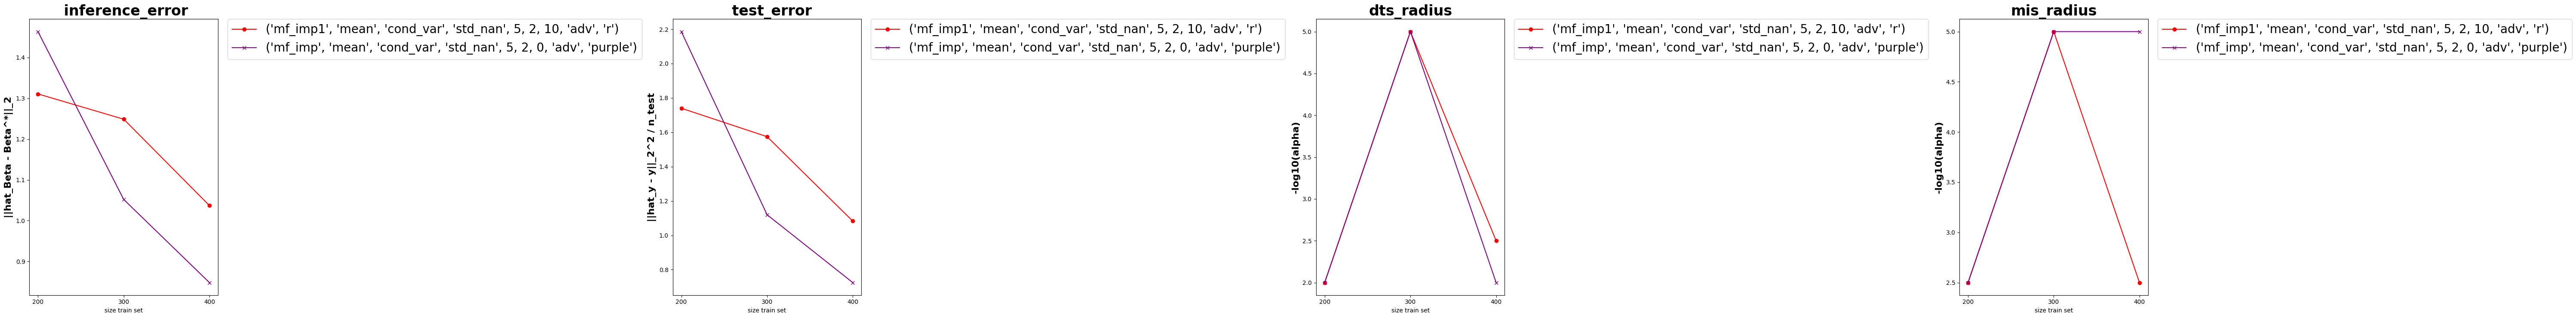

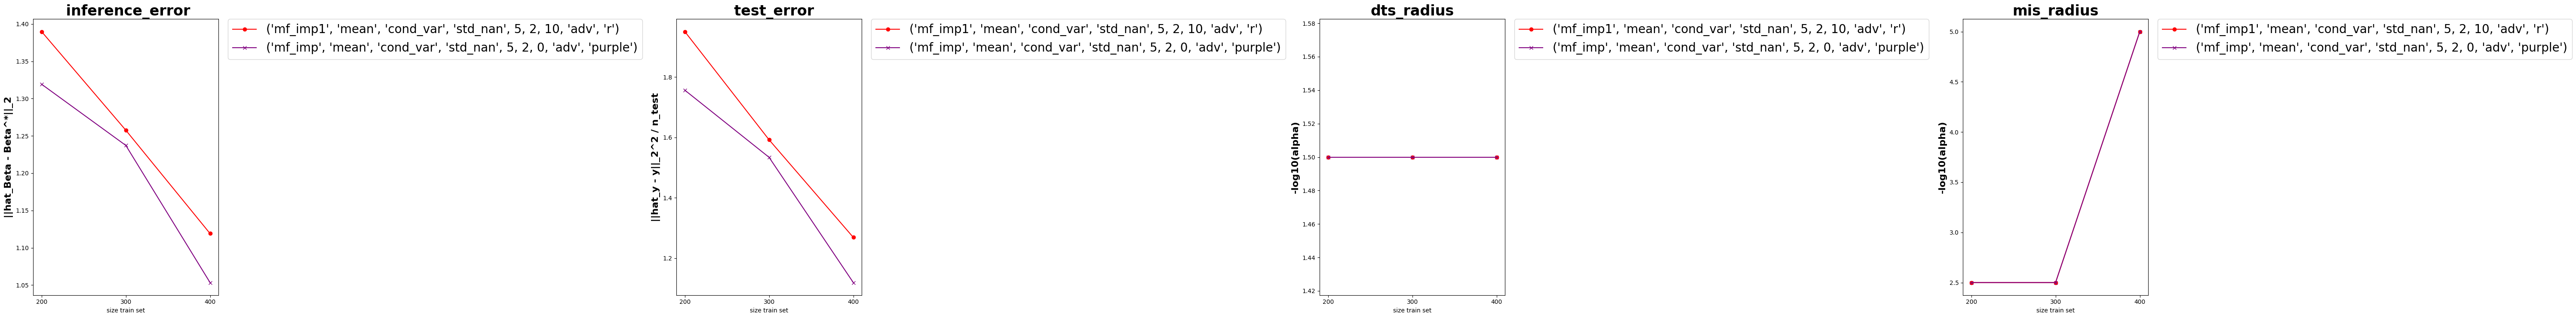

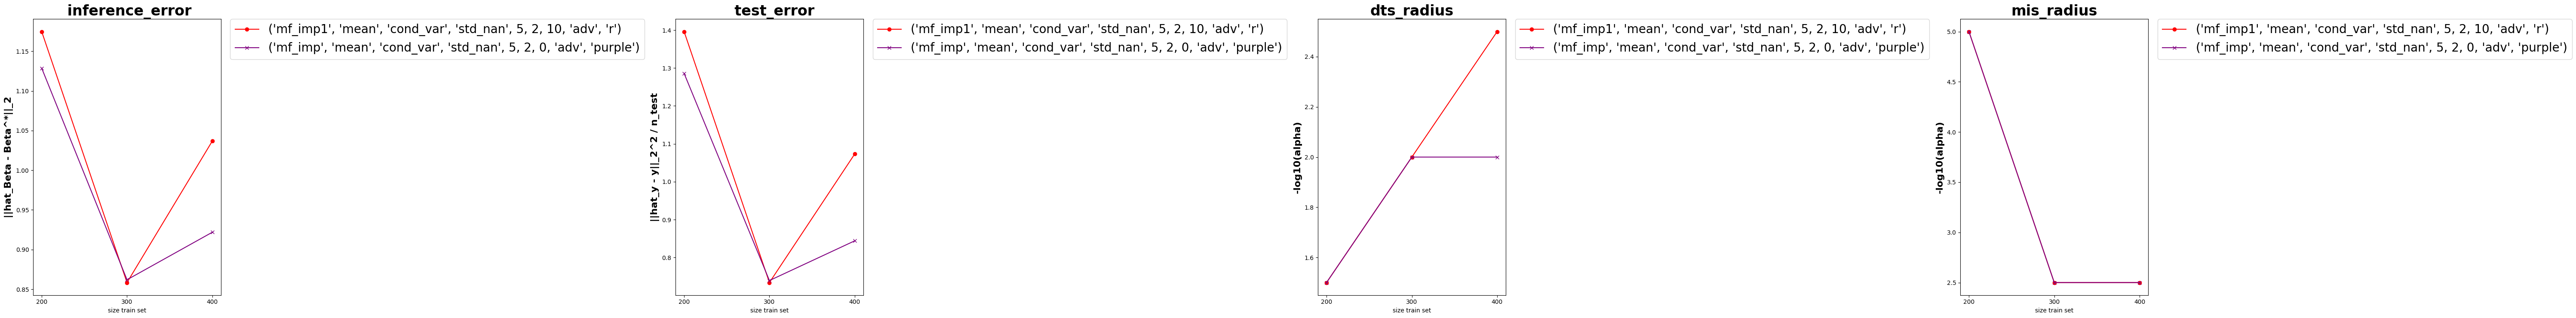

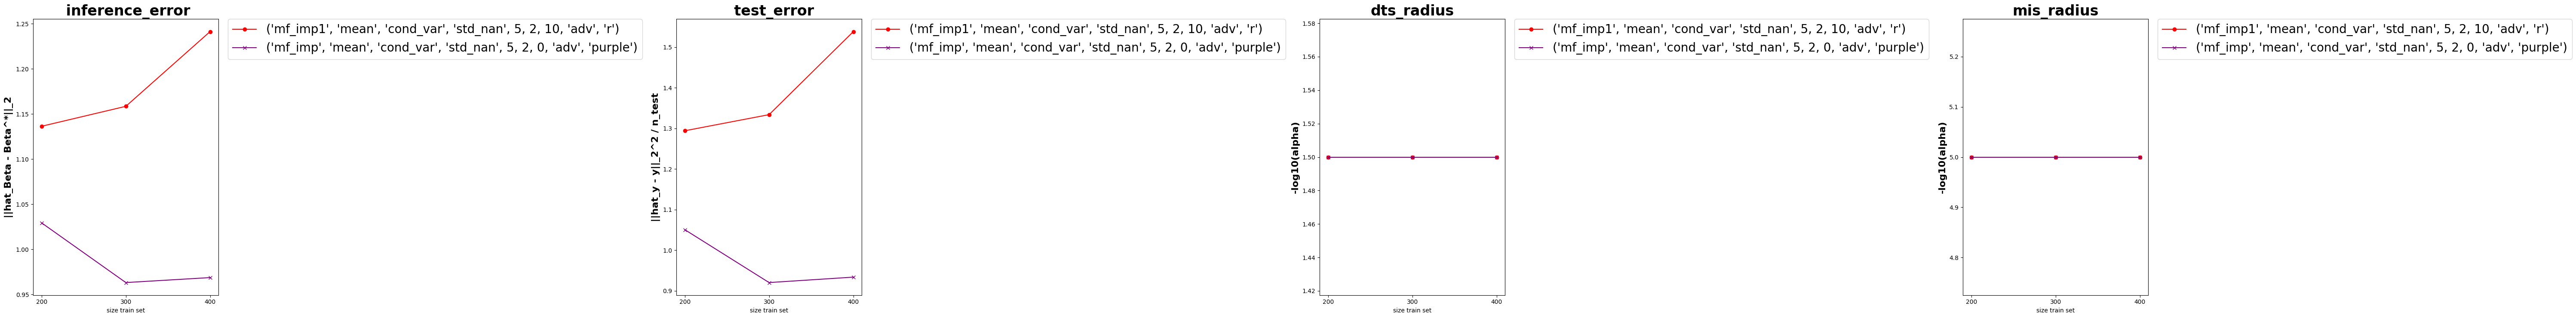

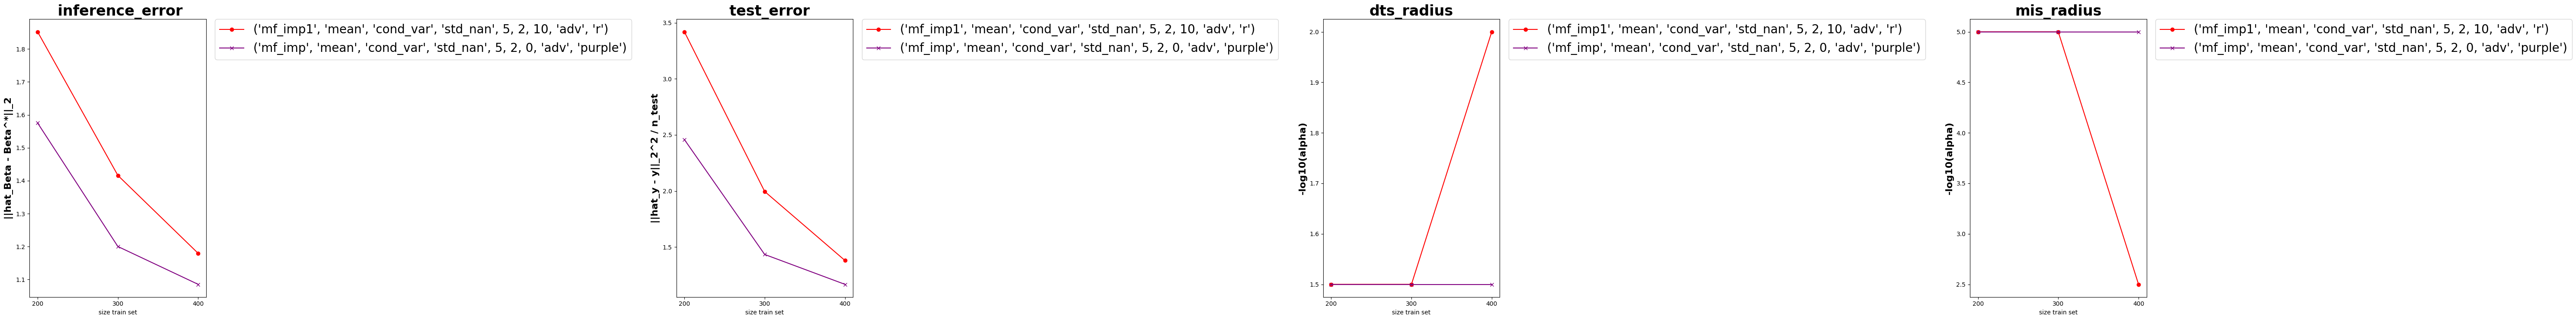

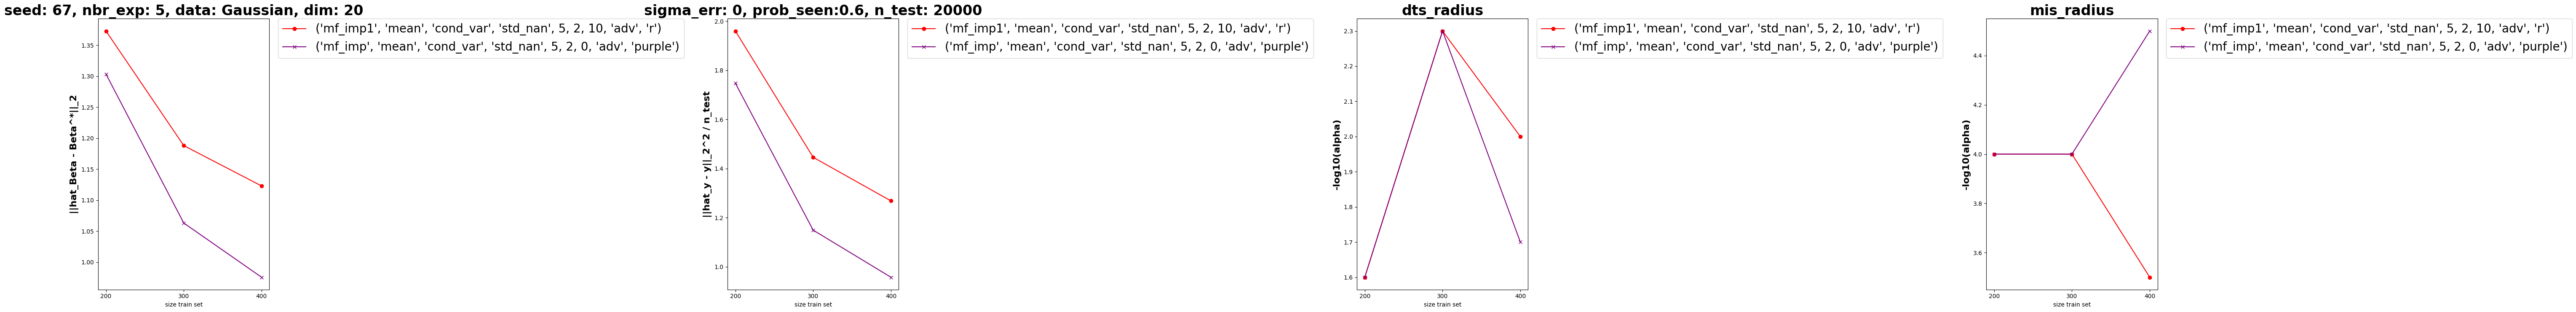

In [8]:

#info_axis = 'train'
#n_train = [400, 800, 1200, 1600, 2000]
#p_seen = make_probabilities([0.8, 0.8, 0.8, 0.8, 0.8])
#main_vec = n_train if info_axis == 'train' else p_seen
#info_x_axis = make_info_axis(main_vec, info_axis)

# def get_path(X, y, estimator, amax, dts_max, mis_max, S_dict, eps_amax=1e-4, eps_dts_max=1e-3, eps_mis_max=1e-3, n_alphas=100, n_deltas_dts=2, n_deltas_mis=3):
gen = 'fixed'
info_axis = 'train'  # train or p_seen
#p_seen_both = [1, 0.95, 0.90, 0.85, 0.80, 0.75, 0.70, 0.65, 0.60, 0.55, 0.50, 0.45, 0.40, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.02]
#p_seen_both = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
#p_seen_both = [1, 0.9, 0.8/0.9, 0.7/0.8, 0.6/0.7, 0.5/0.6]
#p_seen_both = [1, 0.9, 0.8/0.9, 0.7/0.8, 0.6/0.7, 0.5/0.6, 0.4/0.5, 0.3/0.4]
n_train = [200, 300, 400]  # check how dataset are generated, there should be some problems with 'fixed'
lenght_vec = len(n_train)
p_seen_both = [0.6, 1, 1]
#p_seen_both = [1, 0.9, 0.8]
length_vec = len(p_seen_both)
#n_train = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
error_vec =  [0] * length_vec
#p_seen = make_probabilities(p_seen_both)
p_seen = [p_seen_both] * length_vec
if info_axis == 'train':
  main_vec = n_train
  fix_vec = 'prob_seen:' + str(p_seen_both[0])
elif info_axis == 'p_seen':
  main_vec = np.cumprod(p_seen_both)  # p_seen_both
  fix_vec = 'n_train:' + str(n_train[0])
elif info_axis == 'error':
  main_vec = error_vec
#main_vec = n_train if info_axis == 'train' else p_seen_both
info_x_axis = make_info_axis(main_vec, info_axis)
number_test = 20000
#cov_var = 0.6
#beta_gt = np.array([-0.5, 2, 1, 3, -2, -3, 4, 0.5, 7, -9, -1, -2, -3, 4, 5, 6, 7, 8])
#beta_gt = np.array([2, 4, -0.5, 2, 1, 3, -2, -3, 4, 0.5, 7, -9, -1, -2, -3, 4])
beta_gt = np.random.randn(20)
print(beta_gt)
dim = len(beta_gt)
#nbr_feature = int(dim/2)
nbr_feature = int(np.sqrt(dim))
mean = np.array([0] * dim)
matr = np.random.randn(dim, dim) * 1
cov = matr.T @ matr + np.eye(dim) * 3
# np.array([[1, cov_var], [cov_var, 1]])
data_type = 'Gaussian'
#cov = np.array([1, 1, 1])

dicc = make_dictionary_data(
    nbr_experiments= len(main_vec), n_train = n_train, n_test=number_test,
    data = {'data': data_type, 'mean': mean, 'cov': cov},
    beta_gt = beta_gt,
    p_miss = p_seen,
    err_vector = ['Gaussian_on_X', error_vec],
    plots = [] #['points', 'l1_vs_coef', '1/alpha_vs_coef']
)
#dicc = dicc | {'generation':gen}
dicc['what_to_plot'] = ['l2_dist_best_coeff_gt', 'best_score', 'best_alpha_dts']
dicc = dicc | {'generation': gen, 'title_infer_error':' inference_error', 'title_test_error':'  test_error'}
dicc = dicc | {'title_dts_radius': 'dts_radius', 'title_mis_radius': 'mis_radius'}
dicc = dicc | {'info_algo': {'adv_rad_times_delta_dts_max': 100, 'adv_rad_times_delta_mis_max': 1, 'alpha_ridge_reg_max': 100,
                             'eps_adv_rad_times_delta_dts': 1e-7, 'eps_adv_rad_times_delta_mis': 1e-5, 'eps_alpha_ridge_reg': 1e-7,
                             'n_a_dts': 15, 'n_a_mis': 3, 'n_a_rid': 15}}
dicc['what_to_plot'] = ['l2_dist_best_coeff_gt', 'best_score', 'best_alpha_dts', 'best_alpha_mis']

for key, value in dicc.items():
  print(key, ": " , value)

# (imp method, cov strategy, mi_nbr)
#list_imp_cov_methods = [('BR_si', 'sd'), ('l_d', 'sd'), ('mi', 'sd', 1)]

#list_methods_strategy = make_dictionary_method(list_imp_cov_methods)
mi_nbr = 5
nbr_cand = 10
it_mc = 2
# def get_path(X, y, estimator, amax, dts_max, mis_max, S_dict, eps_amax=1e-4, eps_dts_max=1e-3, eps_mis_max=1e-3, n_alphas=100, n_deltas_dts=2, n_deltas_mis=3):

list_methods_strategy = [#{'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'adv', 'color': 'b'},  #, 'multip_dataset': 3, 'multip_missing':0},

                         #{'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge', 'color': 'k'},  #, 'multip_dataset': 3, 'multip_missing':0},
                        #{'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing':3},
                        #{'imp_method': 'oracle', 'cov_strategy': 'zero', 'algo_superv_learn': 'adv'},
                        #{'imp_method': 'oracle', 'cov_strategy': 'zero', 'algo_superv_learn': 'ridge'},  #, 'multip_dataset': 3, 'multip_missing': 0}

                        # {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv', 'color': 'orange'},

                         #{'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge', 'color': 'purple'},
                        #{'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'},#, 'multip_dataset': 3, 'multip_missing':0},
                        #{'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing':3},
                        #{'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn':'ridge'},#, 'multip_dataset': 3, 'multip_missing': 0},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'nbr_feature': dim, 'algo_superv_learn':'adv', 'color':'g'},  #, 'multip_dataset': 3, 'multip_missing': 3},
                        {'imp_method': 'mf_imp1', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'it_mc': it_mc, 'nbr_candidates_mm': nbr_cand, 'algo_superv_learn':'adv', 'color':'r'},  #, 'multip_dataset': 3, 'multip_missing': 3},
                        {'imp_method': 'mf_imp', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'it_mc': it_mc, 'nbr_candidates_mm': 0, 'algo_superv_learn':'adv', 'color':'purple'},  #, 'multip_dataset': 3, 'multip_missing': 3},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': mi_nbr, 'algo_superv_learn':'adv', 'color': 'g'}, #, 'multip_dataset': 3, 'multip_missing': 3},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'zero', 'cov_strategy': 'zero', 'mi_nbr': mi_nbr, 'algo_superv_learn':'adv', 'color': 'r'}
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'algo_superv_learn':'adv'}
                        #{'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 1},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 3},
                        #{'imp_method': 'mi', 'cov_strategy': 'std_mi', 'mi_nbr': mi_nbr},
                        #{'imp_method': 'mi_pure', 'cov_strategy': 'cond_var', 'cov_strategy_within': 'sd', 'mi_nbr': 5},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 1},
                        #{'imp_method': 'mi_mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'eye', 'mi_nbr': 5},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': mi_nbr, 'multip_betw': 0, 'multip_with': 0},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 0.2},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 0.4},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 0.6},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'multip_dataset': 0, 'multip_missing': 0},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'multip_dataset': 0, 'multip_missing': 1},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'multip_dataset': 3, 'multip_missing': 0},
                        #{'imp_method': 'mi', 'post_imp':'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr}#, 'multip_dataset': 3, 'multip_missing': 3}
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 5},
                        ]
print(list_methods_strategy)
for el in list_methods_strategy:
  for key, value in el.items():
    print(key,": " , value)

print("----> Starting experiments")

'''
nbr_exp = 2
#res[key_tuple]['l2_dist_best_coeff_gt'].append(l2_dist)
#res[key_tuple]['best_coeff'].append(coeff_round)
#res[key_tuple]['best_score'].append(score_round)
#res[key_tuple]['best_alpha'].append(alpha_round)
res_l2 = []

rdm_seed = 4654321
np.random.seed(rdm_seed)
res = run_experiments(dicc, list_methods_strategy)
plot_res(info_x_axis, res, dicc)
if nbr_exp > 1:
  for k in res:
    for h in res[k]:
      res[k][h] = [res[k][h]]
  for i in range(nbr_exp-1):
    print("--------------------------------------------------------------------------------------nbr_experiment external ---------------> ", i+2, "-", i+2, " ", i+2, "-", i+2, " ", i+2)
    #np.random.seed(rdm_seed * (i+2))
    res_partial = run_experiments(dicc, list_methods_strategy)
    plot_res(info_x_axis, res_partial, dicc)
    print(res)
    for k in res:
      res[k]['l2_dist_best_coeff_gt'].append(res_partial[k]['l2_dist_best_coeff_gt'])
      res[k]['best_score'].append(res_partial[k]['best_score'])
      res[k]['best_alpha'].append(res_partial[k]['best_alpha'])
      #res[k]['best_coeff'].append(res_partial[k]['best_coeff
    #res.append(res['l2_dist_best_coeff_gt'])

print("final ")
print(res)
for k in res:
  print(k)
  print(np.array(res[k]['l2_dist_best_coeff_gt']))
  print(np.mean(np.array(res[k]['l2_dist_best_coeff_gt']), axis=0))
  print(np.mean(res[k]['l2_dist_best_coeff_gt'], axis=0))
#mean_res = {k: np.mean(v, axis=0) for k, v in res.items()}
mean_res = {k: {v: np.mean(w, axis=0) for v, w in res[k].items()} for k in res}
for k, v in mean_res.items():
  print("k:   ", k)
  for s, t in v.items():
    print(s, ": ", t)
#print(np.mean(res, axis=0))
'''

nbr_exp = 5
seed = 67
mean_res = run_multiple_experiments(nbr_exp, seed, dicc, info_x_axis)
print("PLOT OF THE MEANS")
dicc['title_infer_error'] = 'seed: ' + str(seed) + ', nbr_exp: ' + str(nbr_exp) + ', data: '+ data_type + ', dim: ' + str(dim) # ', cov: ' + str(cov_var)
dicc['title_test_error'] = 'sigma_err: ' + str(error_vec[0]) + ', ' + fix_vec + ', n_test: ' + str(number_test)
#dicc['title_dts_radius'] = 'dts_radius'
#dicc['title_mis_radius'] = 'mis_radius'
#dicc = dicc | {'title_dts_radius': 'title_dts_radius', 'title_mis_radius': 'title_mis_radius'}
#dicc = dicc | {'generation':gen, 'title_infer_error':'mean_infer_error, rep: ' + str(nbr_exp), 'title_mean_error':'mean_test_error'}
#dicc['what_to_plot'] = ['l2_dist_best_coeff_gt', 'best_score', 'best_alpha_dts', 'best_alpha_mis']
plot_res(info_x_axis, mean_res, dicc)

## you can see if you manage to take the index i that maximize alpha




In [ ]:
X = np.random.randint(2, 5, size=(2, 2, 2))
print(X)

XX = np.concatenate(X)
print(XX)


Y = np.random.randint(2, 5, size=(1, 3, 2))
print(Y)

YY = np.concatenate(Y)
print(YY)


Z = np.random.randint(2, 5, size=(5, 2))
print(Z)

ZZ = np.concatenate(Z)
print(ZZ)

print("other")
s = np.random.randint(2, 4, 5)
print(s)
z = np.tile(s, reps=3)  # np.array([s] * 2)
print(z)


print("other mult")
s = np.random.randint(2, 8, size=(3, 2))
print(s)
z = np.tile(s, reps=(3, 1))  # np.array([s] * 2)
print(z)


In [ ]:
'''
## random forest imputer
from sklearn.ensemble import RandomForestRegressor
rf_estimator = RandomForestRegressor(n_estimators=4, max_depth=10, bootstrap=True, max_samples=0.5, n_jobs=2, random_state=0)

X_rf = single_imputation(X_nan, rf_estimator)
print(X_rf.shape)
sd_rf = np.std(X_rf, axis=0)
S_inv_rf = np.diag(1 / sd_rf)
print("std_orig: \n", np.std(X_orig, axis=0))
print("std rf\n ", sd_rf)
fig, ax = plt.subplots(num='advtrain_linf_rf')
linfadvtrain_rf = AdversarialTraining(X_rf, y, S_inv_rf, p=np.inf)
estimator_rf = lambda X, y, a:  linfadvtrain_rf(adv_radius=a)
alphas_adv, coefs_advtrain_linf_rf  = get_path(X_rf, y, estimator_rf, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_rf, ax)
'''

In [ ]:
'''
## iterative imputer Bayesian Ridge

from sklearn.linear_model import BayesianRidge
br_estimator = BayesianRidge()

X_br = single_imputation(X_nan, br_estimator)
sd_br = np.std(X_br, axis=0)
S_inv_br = np.diag(1 / sd_br)
print("std_orig: \n", np.std(X_orig, axis=0))
print("std  br\n ", sd_br)

fig, ax = plt.subplots(num='advtrain_linf_br')
linfadvtrain_br = AdversarialTraining(X_br, y, S_inv_br, p=np.inf)
estimator_br = lambda X, y, a:  linfadvtrain_br(adv_radius=a)
alphas_adv, coefs_advtrain_linf_br  = get_path(X_br, y, estimator_br, 1e4)
plot_coefs_l1norm(coefs_advtrain_linf_br, ax)
'''

In [ ]:
'''
## mean imputation
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
X_mean = imp_mean.fit_transform(X_nan)
sd_mean = np.std(X_mean, axis=0)
print(sd_mean)
S_inv_mean = np.diag(1 / sd_mean)

fig, ax = plt.subplots(num='advtrain_linf_mean')
linfadvtrain_mean = AdversarialTraining(X_mean, y, S_inv_mean, p=np.inf)
estimator_mean = lambda X, y, a:  linfadvtrain_mean(adv_radius=a)
alphas_adv, coefs_advtrain_linf_mean  = get_path(X_mean, y, estimator_mean, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_mean, ax)
'''

In [ ]:
'''
# imputation elliptic

mu = np.nanmean(X_nan, axis=0)
print("means ", mu)
delta = np.mean(masks) # parameter missingness
print("delta ", delta)
X_0 = np.nan_to_num(X_nan)
print("nbr obs", X_0.shape[0])
S_ellp =  X_0.T @ X_0 / X_0.shape[0]
S_ellp = (1/delta - 1/(delta**2)) * np.diag(np.diag(S_ellp)) + 1/(delta**2) * S_ellp
print("eig cov ", np.linalg.eigvalsh(S_ellp))
X_ellp = imputation_elliptic(mu, S_ellp, X_nan, masks)
#S_inv_ellp = np.linalg.inv(S_ellp)  # other variance
sd_inv_ellp = np.std(X_ellp, axis=0)
print("sd ellp", sd_inv_ellp)

fig, ax = plt.subplots(num='advtrain_linf_ellp')
linfadvtrain_ellp = AdversarialTraining(X_ellp, y, S_ellp, p=np.inf)
estimator_ellp = lambda X, y, a:  linfadvtrain_ellp(adv_radius=a)
alphas_adv, coefs_advtrain_linf_ellp  = get_path(X_ellp, y, estimator_ellp, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_ellp, ax)
'''

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np


# Example data
x_test_rect = np.random.rand(10)
y_test_rect = np.random.rand(10)

# Plot the points
fig, ax = plt.subplots()
ax.scatter(x_test_rect, y_test_rect)

width = 0.1
height = 0.1

#add_rectangles(x_test_rect, y_test_rect, width, height, ax)

# Add the rectangle to the plot


In [ ]:
# Cell for some tests

def test_clear_dataset(n, d):
  print("test clear dataset")
  X = np.random.randint(1, 3, size=(n, d))
  y = np.random.randint(1, 3, size=n)
  masks = np.random.binomial(1, 0.3, size=(n, d))
  print("X \n", X)
  print("y\n", y)
  print("masks \n", masks)
  masks[:, 0] = np.ones(n)
  masks[0, :] = np.ones(d)
  X_res, y_res, masks_res = clear_dataset(X, y, masks)
  print("X_res \n", X_res)
  print("y\n", y_res)
  print("masks \n", masks_res)
  print("test clear dataset ended successfully")

def test_generate_X():
    print("test generate_X started")
    fig, ax = plt.subplots(3, 1, figsize=(10, 8), num='advtrain_linf')
    gen = generate_X('circles', 2)
    data = gen(1000)
    print(data.shape)
    ax[0].scatter(data[:, 0], data[:, 1])
    print("test generate passed syccessfully")

def test_preparation_dataset(n, d):
      print("\ntest preparation dataset started")
      X_train = np.random.rand(n, d)
      print("X_train \n", X_train)
      mask = np.random.binomial(1, 0.5, (n, d))
      print("mask, 0 seen, 1 missing \n ", mask)
      X_masked = X_train * (1 - mask)
      print("X_masked \n", X_masked)
      X_nan_train = X_train.copy()
      X_nan_train[mask == 1] = np.nan
      print("X_nan_train \n", X_nan_train)
      X_br_train = single_imputation(X_nan_train, BayesianRidge())
      print("X_br_train\n ", X_br_train)

      print("what happens if we run single_imputation of full dataset")
      X_br_full = single_imputation(X_train, BayesianRidge())
      print("X_br_full\n ", X_br_full)
      np.testing.assert_allclose(X_train, X_br_full)  # shuold be untouched
      print("test preparation dataset ended successfully")

def test_listwise_delection(n, d):
    print("\n test list_wise delection started")
    X = np.random.rand(n, d)
    print("data\n", X)
    mask = np.random.binomial(1, 0.2, (n, d))
    print("mask \n", mask)
    X_ld = listwise_delection(X, mask)
    print("after calling function, X_ld \n", X_ld)

    print("edge cases, all missing")
    mask_1 = np.ones_like(X)  # all missing
    X1 = listwise_delection(X, mask_1)
    print("X1 \n", X1)  # should be empty
    mask_0 = np.zeros_like(X)  # all seen
    X0 = listwise_delection(X, mask_0)
    print("X0 \n", X0)
    np.testing.assert_allclose(X0, X)  # should be the original dataset

    print("one dimnsional array")
    y = np.random.rand(n)
    print("y before ", y)
    y_ld = listwise_delection(y, mask)
    print("y after ld ", y_ld)
    print("test listwise_delection passed")


test_generate_X()
test_preparation_dataset(3, 4)
test_listwise_delection(3, 4)
test_clear_dataset(6, 3)

xxx = np.random.randint(2, 5, size=(3, 3)) * 1.0
mmm = np.random.binomial(1, 0.5, size=(3, 3))
print(xxx)
print(mmm)
print(mmm == 1)
print(xxx[mmm == 1])
xxx[mmm == 1] = np.nan
print(xxx)
mask_from_xxx = np.isnan(xxx).astype(int)
print("mask from xxx \n", mask_from_xxx)


In [ ]:
# test best predictor

def test_best_predictor(n, d, nb_coeff):
  X_test = np.random.randint(1, 9, size=(n, d))
  beta_gt_test = np.random.randint(1, 7, size=d)
  y_test = X_test @ beta_gt_test
  #print("X_test \n", X_test, "\n beta_gt", beta_gt_test, "\n y_test = X_test @ beta_gt_test ", y_test)
  coeff_test = np.random.randint(1, 5, size=(d, nb_coeff))
  rdm_idx = np.random.randint(1, d+1, size=1)
  print(rdm_idx)
  #print("coeff test partial ", coeff_test[:, -1])
  rng = np.arange(nb_coeff)
  #print(rng != rdm_idx)
  coeff_test[:, rng != rdm_idx] = coeff_test[:, rng != rdm_idx] + 1000  # increase artificially the value of the other coefficient, to induce the minimum index to be rdm_idx
  #print("coeff_test \n", coeff_test)
  best_coeff, best_score = best_predictor(X_test, coeff_test, y_test)
  print("best coeff ", best_coeff)
  print("best score ", best_score)
  np.testing.assert_allclose(best_coeff, coeff_test[:,rdm_idx].squeeze())
  print("test best predictor passed")

test_best_predictor(100, 5, 20)




In [ ]:
# test train_and_plot

X_diab, y_diab = datasets.load_diabetes(return_X_y=True)
n, d = X_diab.shape
print("n:  ", n, ", d: ", d)
# Standardize data
X_diab -= X_diab.mean(axis=0)
X_diab /= X_diab.std(axis=0)

## original lasso
fig_l, ax_l = plt.subplots(num='lasso')
alphas_lasso, coefs_lasso, _ = get_lasso_path(X_diab, y_diab)
plot_coefs_l1norm(coefs_lasso, ax_l)

## Antonio's algo, 1 matrix
S_diab_eye = np.eye(X_diab.shape[1])
fig, ax_1 = plt.subplots(1, 1, num='advtrain_linf_diab')
fig, ax_2 = plt.subplots(1, 1, num='advtrain_linf_diab_2')
train_and_plot(X_diab, y_diab, S_diab_eye, [ax_1, ax_2])

## Antonio's algo, multiple diagonal matrix
#S_diab = np.eye(X_diab.shape[1])
#S_diab = np.random.randint(1, 3, size=(n, d))
#print(S_diab)
#fig, ax_5 = plt.subplots(1, 1, num='advtrain_linf_diab_5')
#fig, ax_6 = plt.subplots(1, 1, num='advtrain_linf_diab_6')
#train_and_plot(X_diab, y_diab, S_diab, [ax_5, ax_6])


## Antonio's algo, multiple matrices (same matrix stacked multiple time)
S_diab_stacked = np.array([S_diab_eye] * X_diab.shape[0])
S_diab_stacked = np.concatenate(S_diab_stacked)
fig, ax_3 = plt.subplots(1, 1, num='advtrain_linf_diab_3')
fig, ax_4 = plt.subplots(1, 1, num='advtrain_linf_diab_4')
train_and_plot(X_diab, y_diab, S_diab_stacked, [ax_3, ax_4])




In [ ]:
# test imputations

np.random.seed(45)


def test_imputations(n, d):
  X = np.random.randint(2, 5, size=(n, d)) * 1.0
  y = X @ np.random.randint(1, 3, size=d)
  m = np.random.binomial(1, 0.4, size=(n, d))  # 1 missing, 0 seen
  print("m original\n", m)
  X, y, m = clear_dataset(X, y, m)
  print(m)
  X_nan = X.copy()
  X_nan[m == 1] = np.nan

  #mask_from_xxx = np.isnan(xxx).astype(int)
  print("X\n ", X)
  print("masks \n", m)
  print("X_nan\n ", X_nan)
  methods = ['BR_si', 'mi', 'l_d']
  nbr_mi = [1, 3]
  #for method in methods:
  #  dict_info = {'imp_method': method, 'mi_nbr':nbr_mi}
  #dict_info = {'imp_method':methods, 'mi_nbr':nbr_mi}
  for method in methods:
    print("---------- method: ", method)
    if method == 'mi':
      for x in nbr_mi:
        print("-------------------- nbr mi: ", x)
        dict_info = {'imp_method':method, 'mi_nbr':x}
        #print("XNANNANAN ", X_nan)
        X_res, y_res, mask_res = imputations(dict_info, X_nan, y)
        print(X_res, y_res, "\n", mask_res)
    else:
      dict_info = {'imp_method': method}
      X_res, y_res, mask_res = imputations(dict_info, X_nan, y)
      print(X_res, y_res, "\n", mask_res)
    print("test imputations ended successfully")

test_imputations(6, 3)


In [ ]:
x = []
y = np.array([1, 2])
x.append(y)
x.append(y)
x.append(y)
xx = np.stack(x)
print(x)
print(xx)
print(type(xx))


import matplotlib.pyplot as plt

sizes = [100, 1000, 10000, 100000]
values = [0.8, 0.85, 0.9, 0.92]
positions = range(len(sizes))

plt.plot(positions, values, marker='o', label='Model Accuracy')  # Add label here
plt.xticks(positions, sizes)

plt.xlabel("Dataset Size (equispaced)")
plt.ylabel("Accuracy")
plt.title("Performance vs Dataset Size (equispaced x-axis)")
#plt.legend()  # Show legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()



In [ ]:

dictio = {'a':1, 'b':2, 'c':3}
vv = dictio.values()
#print(vv)
#print(vv[1])

x1 = np.array([1, 2, 3])
x2 = np.array([3, 2 ,1])
v = np.maximum(x1, x2)
print(v)


In [ ]:
m, n, d = 2, 3, 2
x_int = np.random.randint(1, 9, (m, n, d))
print(x_int)
s = np.std(x_int, axis=0)
print(s)

# manual
print("manual computation")
x = np.zeros((m, d))
for i in range(n):
  print("i -----> ", i)
  x = x_int[:, i, :]
  print("x\n", x)
  ss = np.std(x, axis=0)
  print(ss)


print("little exp on squeeze")
sss = np.random.rand(1, 3, 3)
print(sss)
print(sss.squeeze())
print(sss.squeeze())



In [ ]:
int(34.99)

xxxx = np.random.randint(2, 4, (5, 2))
print(xxxx)
xxxx[0:2, :] = 1
print(xxxx)

print("yyyy\n")
yy = []
yy.append([1, 2, 3])
yy.append([4, 5, 6])
print(yy)
print(np.stack( yy ).T)
print("\n\n")
yyy = np.random.randint(1, 10, size=(3 , 3))
print(yyy)
yyy_a = np.array([yyy] * 2)
print(yyy_a.shape)
print(np.concatenate([yyy] * 2))
#print(np.tile(yyy_a, (2, 1, 1) ))

zzz = np.zeros((2, 2))

np.sum(np.zeros((2, 2)) == zzz)

In [ ]:

def multiple_imputation1(nbr_mi, X_nan):
    n, d = X_nan.shape
    res = np.zeros((nbr_mi, n, d))
    for i in range(nbr_mi):
       n_i = np.random.randint(0, 1000)
       ice = IterativeImputer(random_state=n_i, max_iter=50, sample_posterior=True)
       res[i, :, :] = ice.fit_transform(X_nan)
       #print("fin res shape", res.shape)
       #if nbr_mi == 1:
        #res = res[0, :, :]
        #print("fin res shape", res.shape)
    return res


Xx = np.random.randint(1, 3, (4, 4)) * 1.0
mm = np.random.binomial(1, 0.25, (4, 4))
print(Xx)
print(mm)
Xx[mm == 1] = np.nan
print(Xx)

ice = IterativeImputer(random_state=18, max_iter=50, sample_posterior=True)
ice.fit(Xx)
XxX = np.random.randint(1, 3, (2, 4)) * 1.0
mmM = np.random.binomial(1, 0.5, (2, 4))
print(XxX)
print(mmM)
XxX[mmM == 1] = np.nan
print(XxX)

print(ice.transform(XxX))
print(ice.transform(XxX))

print("new")

ls = [[[]],[[]]]
print(ls)
ls[0][0]



In [ ]:
import numpy as np

XX = np.random.randint(1, 7, (2, 3, 3))
print(XX)
XXX = np.tile(XX, (2, 1, 1))
print(XXX)

print(np.zeros(2))

y_o = np.array([1, 2])
y_oo = np.tile(y_o, 3)
print(y_oo)


In [ ]:
import numpy as np
def generate_masks_binomial_general(nbr_of_sample, p_missing):
    # nbr_of_sample is the number of masks
    # p_missing=[p00, p01, p10], where p00 is the probability of seeing both components,
    # p10 is the probability of seeing the right component, p01 is the probability of seeing the left component
    masks = np.zeros((nbr_of_sample, 2))
    v = np.random.choice(a=3, size=nbr_of_sample, p=p_missing)
    masks[v == 0, :] = np.array([0, 0])  # both seen
    masks[v == 1, :] = np.array([0, 1])  # left seen
    masks[v == 2, :] = np.array([1, 0])  # right seen
    return masks


#mm = np.random.binomial(1, [[0.2, 0.2, 0.2], [0.8, 0.8, 0.8]], (2, 3, 3))
#print(mm)
cc = np.array([np.random.binomial(1, x, (4, 4)) for x in [0.2, 0.2, 0.2]])
print(cc)
s_cc = np.cumsum(cc, axis=0)
print(s_cc)
s_cc[s_cc>1] = 1
print(s_cc)

s_v = np.random.randint(1, 4, (3, 4))
print(s_v)
s_vv = s_v[:, None, :] * np.eye(4)
print(s_vv)









In [ ]:
import numpy as np
from sklearn.datasets import make_regression
from sklearn.linear_model import ridge_regression

X = np.random.randn(100, 4) #rng.randn(100, 4)

y = 2.0 * X[:, 0] - 1.0 * X[:, 1] + 0.1 * np.random.randn(100)
np.random.seed(4)
alphas = [0.00001, 0.001, 0.1, 1]
estim = lambda XX, yy, rad: ridge_regression(XX, yy, alpha=rad, return_intercept=False, random_state=0)
for a in alphas:
  #coef, intercept = estim(X, y, a)
  coef = estim(X, y, a)
  print("coef : ", coef)
  #print("intercpt ", intercept)
  coef, intercept = ridge_regression(X, y, alpha=a, return_intercept=True, random_state=0)
  #print("coef : ", coef)
  #print("intercpt ", intercept)


lg = np.random.logistic(loc=0.0, scale=1.0, size=(4, 3))
print("log res ", lg)



In [ ]:
import miceforest as mf
#from sklearn.datasets import load_iris
import pandas as pd
import numpy as np


d = 5
n = 10
print("ciao ")
x = np.random.randint(low=0, high=100, size=(n, d))
x = pd.DataFrame(x)
x.columns = x.columns.astype(str)
m = np.random.binomial(1, 0.3, size=(n, d))
mm = (m==1)
x[mm] = np.nan
print(mm)
print(x)


# Create kernel.
kernel = mf.ImputationKernel(
  x,
  num_datasets=4,
  random_state=1,
  mean_match_candidates=0
)

# Run the MICE algorithm for 2 iterations on each of the datasets

%time kernel.mice(3)


cd1 = kernel.complete_data(dataset=1)
cd2 = kernel.complete_data(dataset=2)
#print("cd1\n", cd1, "\ncd2\n", cd2)
res = np.zeros((4, n, d))

for i in range(4):
  res[i, :, :] = kernel.complete_data(dataset=i)

print("res\n ", res)

# Printing the kernel will show you some high level information.
print(kernel)



In [ ]:
# test miceforest

np.random.seed(11)


def test_miceforest(n, d, p_seen, nbr_c):
    x_mf_test = np.random.randint(low=0, high=99, size=(n, d)) + 0.0
    m_mf_test = np.random.binomial(1, p_seen, size=(n, d))
    x_mf_test[m_mf_test == 1] = np.nan
    print(x_mf_test)
    info_mf_test = {'mi_nbr': 2, 'nbr_candidates_mm': nbr_c}

    print(np.isnan(x_mf_test))
    print(np.isnan(x_mf_test).sum() )


    res = miceforest_imputation(info_mf_test, x_mf_test)
    print(res)



test_miceforest(n=13, d=5, p_seen=0.3, nbr_c=0)

